In [1]:
# https://www.kaggle.com/asmitavikas/feature-engineered-0-68310
import numpy as np
import pandas as pd
import lightgbm as lgb
import datetime
import math

In [2]:
import os
cwd = os.getcwd()
print("Current directory: %s" % cwd)

print('Loading data...')
data_path = '../../kaggle/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
songs = pd.read_csv(data_path + 'songs.csv')
members = pd.read_csv(data_path + 'members.csv',
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')
print('Done loading...')

Current directory: /home/jiacheliu3/Kaggle/kkbox-music-recommendation/data
Loading data...
Done loading...


In [3]:
print('Member table:')
print(members.info())

print('Song table:')
print(songs.info())

print('Song extra info table:')
print(songs_extra.info())

Member table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
msno                      34403 non-null object
city                      34403 non-null int64
bd                        34403 non-null int64
gender                    14501 non-null object
registered_via            34403 non-null int64
registration_init_time    34403 non-null datetime64[ns]
expiration_date           34403 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 1.8+ MB
None
Song table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
song_id        object
song_length    int64
genre_ids      object
artist_name    object
composer       object
lyricist       object
language       float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB
None
Song extra info table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295971 entries, 0 to 2295970
Data 

# Engineering members table

In [4]:
from datetime import datetime
# Convert datetime to int timestamp
def to_timestamp(x):
    return datetime.timestamp(x)

In [5]:
members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(np.int16)

# Convert datetime to int
members['registration_timestamp']=members['registration_init_time'].apply(to_timestamp)
members['expiration_timestamp']=members['expiration_date'].apply(to_timestamp)

In [7]:
# Drop date columns
members.drop(['registration_init_time', 'expiration_date'], axis=1, inplace=True)

In [6]:
# Phase 5: Not splitting anymore as timestamps make more sense

# members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(np.int16)

# members['registration_year'] = members['registration_init_time'].dt.year
# members['registration_month'] = members['registration_init_time'].dt.month
# members['registration_date'] = members['registration_init_time'].dt.day

# members['expiration_year'] = members['expiration_date'].dt.year
# members['expiration_month'] = members['expiration_date'].dt.month
# members['expiration_date'] = members['expiration_date'].dt.day

# Engineering songs table

In [8]:
# Convert to lower case
# NaN values are kept for replacement
def to_lower_case(X, list_of_columns):
    for col in list_of_columns:
        print("Converting column %s" % col)
        X[col]=X[col].str.lower()

In [9]:
# Song length
MEAN_SONG_LENGTH = int(round(np.mean(songs['song_length'])))
STD_SONG_LENGTH = int(round(np.std(songs['song_length'])))
print("Song length mean: %i  std: %i" % (MEAN_SONG_LENGTH, STD_SONG_LENGTH))

Song length mean: 246993  std: 160920


In [10]:
# Fill with mean length
songs.song_length.fillna(MEAN_SONG_LENGTH,inplace=True)

In [11]:
def shorter_song(x):
    if x < MEAN_SONG_LENGTH:
        return 1
    return 0

songs['short_song'] = songs['song_length'].apply(shorter_song).astype(np.int8)
songs['short_song'] = songs['song_length'].apply(shorter_song).astype(np.int8)

In [12]:
# How many std is the song length from mean
def mean_length_dist(x):
    return x-MEAN_SONG_LENGTH

songs['mean_length_distance'] = songs['song_length'].apply(mean_length_dist).astype(np.uint16)
songs['mean_length_distance'] = songs['song_length'].apply(mean_length_dist).astype(np.uint16)

In [13]:
# Cast to lower letters
cols_to_lower=['artist_name', 'composer', 'lyricist']
to_lower_case(songs, cols_to_lower)

Converting column artist_name
Converting column composer
Converting column lyricist


# Engineering songs_extra table

In [14]:
'''
ISRC is in the form "CC-XXX-YY-NNNNN"
CC: Country code
XXX: Issuer
YY: Year
NNNNN: Unique identifier
'''
def split_isrc(x):
    if type(x) == str:
        country=x[0:2]
        issuer=x[2:5]
        if int(x[5:7]) > 17:
            year=1900 + int(x[5:7])
        else:
            year=2000 + int(x[5:7])
        unique_code=x[7:12]
        
        return country, issuer, year, unique_code
    else:
        return "empty", "empty", np.NaN, "empty"  
    


In [15]:
# Split isrc into 4 columns
S=songs_extra['isrc'].apply(split_isrc).to_frame()
songs_extra[['country_code', 'issuer', 'issue_year' ,'unique_id']]=pd.DataFrame(S['isrc'].tolist())

In [16]:
# Safely drop isrc
songs_extra.drop(['isrc'], axis=1, inplace=True)

In [17]:
# Rename column 'name' to 'song_name' to avoid confusion
songs_extra.rename(columns={"name": "song_name"}, inplace=True)

# Merge tables

In [18]:
# Merge songs
train = train.merge(songs, on='song_id', how='left')
test = test.merge(songs, on='song_id', how='left')

# Merge members
train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

# Merge songs_extra
train = train.merge(songs_extra, on = 'song_id', how = 'left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')

In [19]:
TRAIN_SIZE=train.shape[0]
print("%i rows in train set" % TRAIN_SIZE)

TEST_SIZE=test.shape[0]
print("%i rows in test set" % TEST_SIZE)

7377418 rows in train set
2556790 rows in test set


In [20]:
# List current columns
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 26 columns):
msno                      object
song_id                   object
source_system_tab         object
source_screen_name        object
source_type               object
target                    int64
song_length               float64
genre_ids                 object
artist_name               object
composer                  object
lyricist                  object
language                  float64
short_song                float64
mean_length_distance      float64
city                      int64
bd                        int64
gender                    object
registered_via            int64
membership_days           int16
registration_timestamp    float64
expiration_timestamp      float64
song_name                 object
country_code              object
issuer                    object
issue_year                float64
unique_id                 object
dtypes: float64(7), int16(1

In [23]:
# Remove newline characters from string fields
def replace_if_string(x):
    if type(x) is str:
        return x.replace('\n', '')
    else:
        return x

def remove_newline(X):
    X_nobreak = pd.concat([
        X.select_dtypes([], ['object']),
        X.select_dtypes(['object']).apply(lambda M: M.apply(lambda s: replace_if_string(s)))
        ], axis=1).reindex_axis(X.columns, axis=1)
    print("After removing newline")
    print(X_nobreak.info())
    return X_nobreak

In [24]:
# Remove newline from all columns
train=remove_newline(train)
test=remove_newline(test)

/home/jiacheliu3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


After removing newline
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 26 columns):
msno                      object
song_id                   object
source_system_tab         object
source_screen_name        object
source_type               object
target                    int64
song_length               float64
genre_ids                 object
artist_name               object
composer                  object
lyricist                  object
language                  float64
short_song                float64
mean_length_distance      float64
city                      int64
bd                        int64
gender                    object
registered_via            int64
membership_days           int16
registration_timestamp    float64
expiration_timestamp      float64
song_name                 object
country_code              object
issuer                    object
issue_year                float64
unique_id                 object
dtyp

In [34]:
# Stop here and examine all columns
train.describe()

/home/jiacheliu3/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/jiacheliu3/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,target,song_length,language,short_song,mean_length_distance,city,bd,registered_via,membership_days,registration_timestamp,expiration_timestamp,issue_year
count,7.377418e+06,7.377304e+06,7.377268e+06,7.377304e+06,7.377304e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,6.799560e+06
mean,5.035171e-01,2.451210e+05,1.860933e+01,5.442132e-01,3.261635e+04,7.511399e+00,1.753927e+01,6.794068e+00,1.627961e+03,1.365339e+09,1.505995e+09,2.011230e+03
std,4.999877e-01,6.734471e+04,2.117681e+01,4.980414e-01,1.840872e+04,6.641625e+00,2.155447e+01,2.275774e+00,1.128673e+03,9.527880e+07,1.107399e+07,6.682440e+00
min,0.000000e+00,1.393000e+03,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-4.300000e+01,3.000000e+00,-1.619100e+04,1.080259e+09,0.000000e+00,1.918000e+03
25%,0.000000e+00,NaN,NaN,NaN,NaN,1.000000e+00,0.000000e+00,4.000000e+00,7.010000e+02,1.309824e+09,1.505088e+09,NaN
50%,1.000000e+00,NaN,NaN,NaN,NaN,5.000000e+00,2.100000e+01,7.000000e+00,1.433000e+03,1.382486e+09,1.506384e+09,NaN
75%,1.000000e+00,NaN,NaN,NaN,NaN,1.300000e+01,2.900000e+01,9.000000e+00,2.286000e+03,1.445472e+09,1.507248e+09,NaN
max,1.000000e+00,1.085171e+07,5.900000e+01,1.000000e+00,6.553500e+04,2.200000e+01,1.051000e+03,1.300000e+01,5.149000e+03,1.485821e+09,1.602893e+09,2.017000e+03


Fill empty before output

In [25]:
# Fill source_system_tab
train['source_system_tab'].replace([np.nan, 'null'], 'empty', inplace=True)
test['source_system_tab'].replace([np.nan, 'null'], 'empty', inplace=True)

# Fill source_screen_name 
train['source_screen_name'].replace([np.nan], 'empty', inplace=True)
test['source_screen_name'].replace([np.nan], 'empty', inplace=True)

# Fill source_type 
train['source_type'].replace([np.nan], 'empty', inplace=True)
test['source_type'].replace([np.nan], 'empty', inplace=True)

In [26]:
# Fill song_length
train['song_length'].replace([np.nan], MEAN_SONG_LENGTH, inplace=True)
test['song_length'].replace([np.nan], MEAN_SONG_LENGTH, inplace=True)

In [27]:
# Fill language
train['language'].replace([np.nan], 0.0, inplace=True)
test['language'].replace([np.nan], 0.0, inplace=True)

In [28]:
# Fill short_song
train['short_song'].replace([np.nan], 0, inplace=True)
test['short_song'].replace([np.nan], 0, inplace=True)

In [29]:
# Fill mean_length_distance 
train['mean_length_distance'].replace([np.nan], 0.0, inplace=True)
test['mean_length_distance'].replace([np.nan], 0.0, inplace=True)

In [30]:
# Fill gender 
train['gender'].replace([np.nan], 'unknown', inplace=True)
test['gender'].replace([np.nan], 'unknown', inplace=True)

In [31]:
# Fill song_name
train['song_name'].replace([np.nan], 'empty', inplace=True)
test['song_name'].replace([np.nan], 'empty', inplace=True)

In [32]:
# Fill country_code
train['country_code'].replace([np.nan], 'empty', inplace=True)
test['country_code'].replace([np.nan], 'empty', inplace=True)

# Fill issuer
train['issuer'].replace([np.nan], 'empty', inplace=True)
test['issuer'].replace([np.nan], 'empty', inplace=True)

# Fill issue_year
train['issue_year'].replace([np.nan], 0.0, inplace=True)
test['issue_year'].replace([np.nan], 0.0, inplace=True)

# Fill unique_id
train['unique_id'].replace([np.nan], 'empty', inplace=True)
test['unique_id'].replace([np.nan], 'empty', inplace=True)

In [33]:
# Fill genre_ids
train['genre_ids'].replace([np.nan], 'empty', inplace=True)
test['genre_ids'].replace([np.nan], 'empty', inplace=True)

In [34]:
def find_nan(X):
    for c in X.columns:
        has_null=X[c].isnull().values.any()
        if has_null:
            print("Column %s has null" % c)

In [35]:
find_nan(train)

Column artist_name has null
Column composer has null
Column lyricist has null


In [36]:
# Some age information are incorrect
train['bd'].unique()

array([   0,   24,   26,   27,   18,   34,   20,   19,   28,   41,   32,
         36,   46,   30,   23,   67,   22,   29,   21,   31,   39,   35,
         16,   25,   38,   17,   43,   47,   33,   37,   44,   49,   50,
         40,   52,   45,   53,   64,   57,   48,   51,   59,   54,   42,
         55,    3,  111,   65,   73,   60,   58,   56,   66,   14,  131,
         74,   62,   61,   63,    7,  103, 1030,  -43,   15,  105,  107,
         68,   13,  931,   72,   11,    2,   87,  144,   95,   83,   12,
         93,    5,  112,   90,   10,   70,  -38,   82,   89,  106,  102,
         85, 1051,   78,   76])

In [37]:
def filter_birthday(x):
    if x<10 or x>70:
        # False info
        return np.nan
    else:
        return x

In [38]:
# Get rid of falseful ages
train['bd']=train['bd'].apply(filter_birthday)
test['bd']=test['bd'].apply(filter_birthday)

In [39]:
print(train['bd'].mean())
print(test['bd'].mean())

28.696307466568665
28.82796897786027


In [40]:
# Re-fill with credible mean
train['bd'].replace([np.nan], 29, inplace=True)
test['bd'].replace([np.nan], 29, inplace=True)

Plotting distribution of some columns

In [41]:
%matplotlib inline  
plt.figure()
train['song_length'].plot.hist(bins=50, range=[0.0, 600000])

NameError: name 'plt' is not defined

In [ ]:
plt.figure()
train['city'].plot.hist(range=[0, 25])

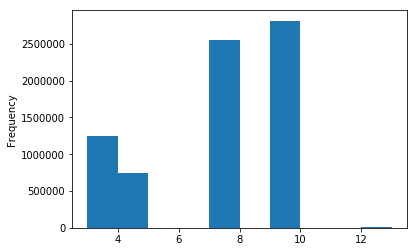

In [88]:
plt.figure()
train['registered_via'].plot.hist()

In [90]:
train['registered_via'].unique()

array([ 7,  9,  4,  3, 13])

In [91]:
train['expiration_date'].unique()

array([ 5, 11,  4, 30, 22, 12,  9, 13, 16,  1,  3,  2, 25,  7,  8,  6, 14,
       23, 10, 15, 24, 18, 17, 19, 20, 26, 29, 28, 21, 31, 27])

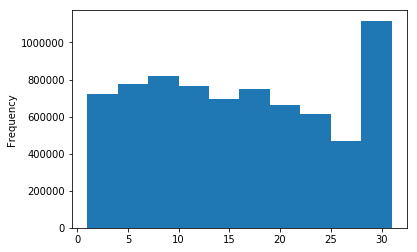

In [89]:
plt.figure()
train['expiration_date'].plot.hist()

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 26 columns):
msno                      object
song_id                   object
source_system_tab         object
source_screen_name        object
source_type               object
target                    int64
song_length               float64
genre_ids                 object
artist_name               object
composer                  object
lyricist                  object
language                  float64
short_song                float64
mean_length_distance      float64
city                      int64
bd                        float64
gender                    object
registered_via            int64
membership_days           int16
registration_timestamp    float64
expiration_timestamp      float64
song_name                 object
country_code              object
issuer                    object
issue_year                float64
unique_id                 object
dtypes: float64(8), int16

Phase 1 feature engineering:
31 features

0.66770 without cv

# Phase 2 feature engineering

In [42]:
# Copy to new start
train_2=train.copy()
test_2=test.copy()

In [43]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 26 columns):
msno                      object
song_id                   object
source_system_tab         object
source_screen_name        object
source_type               object
target                    int64
song_length               float64
genre_ids                 object
artist_name               object
composer                  object
lyricist                  object
language                  float64
short_song                float64
mean_length_distance      float64
city                      int64
bd                        float64
gender                    object
registered_via            int64
membership_days           int16
registration_timestamp    float64
expiration_timestamp      float64
song_name                 object
country_code              object
issuer                    object
issue_year                float64
unique_id                 object
dtypes: float64(8), int16

In [44]:
# GC old df
import gc
del train, test
del songs, members, songs_extra
gc.collect()

91

In [56]:
len(train_2['issuer'].unique())

6456

# Fille empty in genre_id/artist/composer/lyricist 

In [45]:
NO_GENRE_FILL="empty"
def genre_id_count(x):
    if x == NO_GENRE_FILL:
        return 0
    else:
        return x.count('|') + 1

In [46]:
# this add_categories can only be run once
train_2['genre_ids'].fillna(NO_GENRE_FILL,inplace=True)
test_2['genre_ids'].fillna(NO_GENRE_FILL,inplace=True)
train_2['genre_ids_count'] = train_2['genre_ids'].apply(genre_id_count).astype(np.int8)
test_2['genre_ids_count'] = test_2['genre_ids'].apply(genre_id_count).astype(np.int8)

In [47]:
NO_LYRICIST_FILL="empty"
def lyricist_count(x):
    if x == NO_LYRICIST_FILL:
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    return sum(map(x.count, ['|', '/', '\\', ';']))

In [48]:
# this add_categories can only be run once
train_2['lyricist'].fillna(NO_LYRICIST_FILL,inplace=True)
test_2['lyricist'].fillna(NO_LYRICIST_FILL,inplace=True)
train_2['lyricists_count'] = train_2['lyricist'].apply(lyricist_count).astype(np.int8)
test_2['lyricists_count'] = test_2['lyricist'].apply(lyricist_count).astype(np.int8)

In [49]:
NO_COMPOSER_FILL="empty"
def composer_count(x):
    if x == NO_COMPOSER_FILL:
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

In [50]:
# this add_categories can only be run once
train_2['composer'].fillna(NO_COMPOSER_FILL,inplace=True)
test_2['composer'].fillna(NO_COMPOSER_FILL,inplace=True)
train_2['composer_count'] = train_2['composer'].apply(composer_count).astype(np.int8)
test_2['composer_count'] = test_2['composer'].apply(composer_count).astype(np.int8)

In [51]:
NO_ARTIST_FILL='empty'
    
def artist_count(x):
    if x == NO_ARTIST_FILL:
        return 0
    else:
        count = x.count(',') + x.count('&') + x.count('+') + x.count('|')
        # Add English separators
        count += x.count('and') + x.count('feat')
        # Add Chinese separators
        count += x.count('，') + x.count('、') + x.count('＆') + x.count('＋')
        
        return count

In [52]:
train_2['artist_name'].fillna(NO_ARTIST_FILL,inplace=True)
test_2['artist_name'].fillna(NO_ARTIST_FILL,inplace=True)
train_2['artist_count'] = train_2['artist_name'].apply(artist_count).astype(np.int8)
test_2['artist_count'] = test_2['artist_name'].apply(artist_count).astype(np.int8)

In [53]:
NO_SONG_NAME_FILL='empty'
train_2['song_name'].fillna(NO_SONG_NAME_FILL,inplace=True)
test_2['song_name'].fillna(NO_SONG_NAME_FILL,inplace=True)

# Check if the song is featured/acoustic/instrumental/remix

In [54]:
def is_featured(x):
    if 'feat' in str(x) :
        return 1
    return 0

In [55]:
# Find if the song is featured
train_2['is_featured_artist'] = train_2['artist_name'].apply(is_featured).astype(np.int8)
test_2['is_featured_artist'] = test_2['artist_name'].apply(is_featured).astype(np.int8)

In [56]:
# Find if the song is featured by song name
train_2['is_featured_song'] = train_2['song_name'].apply(is_featured).astype(np.int8)
test_2['is_featured_song'] = test_2['song_name'].apply(is_featured).astype(np.int8)

In [57]:
# Find if the song is featured
train_2['is_featured'] = train_2['is_featured_artist'] | train_2['is_featured_song']
test_2['is_featured'] = test_2['is_featured_artist'] | test_2['is_featured_song']

In [58]:
# Drop featured check for separate song_name and artist_name
train_2.drop(['is_featured_artist', 'is_featured_song'], axis=1, inplace=True)
test_2.drop(['is_featured_artist', 'is_featured_song'], axis=1, inplace=True)

In [59]:
# Look at artist names that contains 'feat'
check_feat=train_2.loc[train_2['is_featured'] == 1]
check_feat[['artist_name', 'song_name']]

,artist_name,song_name
12,林俊傑 (jj lin),手心的薔薇 (Beautiful) feat. G.E.M.鄧紫棋
53,謝和弦 (r-chord),在沒有你以後 (feat. 張智成) (Without You)
55,林俊傑 (jj lin),手心的薔薇 (Beautiful) feat. G.E.M.鄧紫棋
137,劉佳,愛很美-feat.sara
180,david guetta,Hey Mama (feat. Nicki Minaj| Bebe Rexha & Afro...
184,major lazer,Cold Water (feat. Justin Bieber & MØ)
186,major lazer,Lean On (feat. MØ & DJ Snake)
187,david guetta,Titanium (feat. Sia)
207,alex goot feat. kurt hugo schneider & atc,Let Me Love You
414,謝和弦 (r-chord),在沒有你以後 (feat. 張智成) (Without You)


In [60]:
# Find the main and featuring artist names
def feat_name(x):
    if 'feat.' in str(x) :
        idx=x.find('feat.')
        feat_name=x[idx+5:].strip()
        return feat_name
    elif 'feat' in str(x) :
        idx=x.find('feat')
        feat_name=x[idx+5:].strip()
        return feat_name
    return "empty"
def main_name(x):
    if 'feat' in str(x) :
        idx=x.find('feat')
        main_name=x[:idx].strip()
        return main_name
    return x

In [61]:
# Split featuring artist names
train_2['feat_artist'] = train_2['artist_name'].apply(feat_name)
test_2['feat_artist'] = test_2['artist_name'].apply(feat_name)

train_2['main_artist'] = train_2['artist_name'].apply(main_name)
test_2['main_artist'] = test_2['artist_name'].apply(main_name)

# Split featuring song names
train_2['feat_song_name'] = train_2['song_name'].apply(feat_name)
test_2['feat_song_name'] = test_2['song_name'].apply(feat_name)

train_2['main_song_name'] = train_2['song_name'].apply(main_name)
test_2['main_song_name'] = test_2['song_name'].apply(main_name)


In [62]:
def is_remix(x):
    if 'remix' in str(x):
        return 1
    return 0

In [63]:
train_2['is_remix_artist']=train_2['artist_name'].apply(is_remix).astype(np.int8)
test_2['is_remix_artist']=test_2['artist_name'].apply(is_remix).astype(np.int8)

train_2['is_remix_song']=train_2['song_name'].apply(is_remix).astype(np.int8)
test_2['is_remix_song']=test_2['song_name'].apply(is_remix).astype(np.int8)

train_2['is_remix'] = train_2['is_remix_artist'] | train_2['is_remix_song']
test_2['is_remix'] = test_2['is_remix_artist'] | test_2['is_remix_song']

In [64]:
# Drop remix check for separate song_name and artist_name
train_2.drop(['is_remix_artist', 'is_remix_song'], axis=1, inplace=True)
test_2.drop(['is_remix_artist', 'is_remix_song'], axis=1, inplace=True)

In [65]:
# Look at artist names that contains 'remix'
check_remix=train_2.loc[train_2['is_remix'] == 1]
check_remix[['artist_name','song_name']]

,artist_name,song_name
2901,dj remix factory,Where Are U Now (DJ Remixed)
12699,nowhere樂團 (nowhere band),1984 remix special
18877,蔡依林 (jolin tsai),MR.Q（All Night Party remixed by DJ Submarine） ...
26418,群星 (remix 101),男人KTV (Karaoke Men)
30596,various artists (bhangra remixes),The Fox (What Does The Fox Say?)
37821,g-dragon,THIS LOVE (FEAT.G.H remix)
38495,ayumi hamasaki (浜崎あゆみ),Feel the love 敢愛 (DJ Hello Kitty remix)
38607,dj remix factory,Payphone
39552,seoan,What is Right? (Downtempo remix)
49608,billboard masters,Dessert (remix) - Tribute to Dawin and Silento


In [66]:
def is_live(x):
    live_keywords=[' live', '现场', '現場', '演唱會', '演唱会', '演出']
    # some sings name start with 'live'
    if any(s in str(x) for s in live_keywords):
        return 1
    return 0

In [67]:

train_2['is_live_artist']=train_2['artist_name'].apply(is_live).astype(np.int8)
test_2['is_live_artist']=test_2['artist_name'].apply(is_live).astype(np.int8)

train_2['is_live_song']=train_2['song_name'].apply(is_live).astype(np.int8)
test_2['is_live_song']=test_2['song_name'].apply(is_live).astype(np.int8)

train_2['is_live'] = train_2['is_live_artist'] | train_2['is_live_song']
test_2['is_live'] = test_2['is_live_artist'] | test_2['is_live_song']

In [68]:
# Drop live check for separate song_name and artist_name
train_2.drop(['is_live_artist', 'is_live_song'], axis=1, inplace=True)
test_2.drop(['is_live_artist', 'is_live_song'], axis=1, inplace=True)

In [69]:
# Look at artist names that contains 'live'
check_live=train_2.loc[train_2['is_live'] == 1]
check_live[['artist_name', 'song_name']]

,artist_name,song_name
2380,五月天 (mayday),諾亞方舟【2012世界巡迴演唱會「諾亞方舟」主題曲】
8137,郭靜 (claire kuo),放肆一下 (Wild Things) - <Fun 4 一夏>福茂女朋友 演唱會主題歌
10058,五月天 (mayday),諾亞方舟【2012世界巡迴演唱會「諾亞方舟」主題曲】
10204,五月天 (mayday),如煙+如果還有明天 【五月天諾亞方舟世界巡迴演唱會LIVE版】
11520,五月天 (mayday),諾亞方舟【2012世界巡迴演唱會「諾亞方舟」主題曲】
13553,張國榮 (leslie cheung),我(熱情演唱會壓軸主題曲)
16676,五月天 (mayday),愛情萬歲【五月天諾亞方舟世界巡迴演唱會LIVE版】
16681,五月天 (mayday),2012【五月天諾亞方舟世界巡迴演唱會LIVE版】
23907,五月天 (mayday),諾亞方舟【2012世界巡迴演唱會「諾亞方舟」主題曲】
28772,五月天 (mayday),諾亞方舟【2012世界巡迴演唱會「諾亞方舟」主題曲】


In [70]:
def is_acoustic(x):
    acoustic_keywords=['acoustic', '原声', '原聲']
    # some sings name start with 'live'
    if any(s in str(x) for s in acoustic_keywords):
        return 1
    return 0

In [71]:
train_2['is_acoustic_artist']=train_2['artist_name'].apply(is_acoustic).astype(np.int8)
test_2['is_acoustic_artist']=test_2['artist_name'].apply(is_acoustic).astype(np.int8)

train_2['is_acoustic_song']=train_2['song_name'].apply(is_acoustic).astype(np.int8)
test_2['is_acoustic_song']=test_2['song_name'].apply(is_acoustic).astype(np.int8)

train_2['is_acoustic'] = train_2['is_acoustic_artist'] | train_2['is_acoustic_song']
test_2['is_acoustic'] = test_2['is_acoustic_artist'] | test_2['is_acoustic_song']

In [72]:
# Drop live check for separate song_name and artist_name
train_2.drop(['is_acoustic_artist', 'is_acoustic_song'], axis=1, inplace=True)
test_2.drop(['is_acoustic_artist', 'is_acoustic_song'], axis=1, inplace=True)

In [73]:
# Look at artist names that contains 'remix'
check_acoustic=train_2.loc[train_2['is_acoustic'] == 1]
check_acoustic[['artist_name', 'song_name']]

,artist_name,song_name
103,相愛穿梭千年 電視原聲帶,相愛不能見
112,16個夏天 電視原聲帶,浪漫來襲 (Romance Strikes)
144,生日快樂電影原聲帶,I MISS YOU
146,生日快樂電影原聲帶,生日快樂
149,生日快樂電影原聲帶,回憶
213,16個夏天 電視原聲帶,公轉自轉 (Gong Zhuan Zi Zhuan)
467,沒關係 是愛情啊 電視原聲帶 volume 1,最佳的幸運 (Sung by CHEN(EXO))
606,16個夏天 電視原聲帶,以後別做朋友 (Yi Hou Bie Zuo Peng You)
662,22k夢想高飛 電視原聲帶,藏不住
855,我的祕密飯店 電視原聲帶,Secret Killer (Inst.) - Studio Musicians


In [74]:
def is_instrumental(x):
    intru_keywords=['instrumental', 'インスト', '配樂', '配乐', '伴奏']
    # some sings name start with 'live'
    if any(s in str(x) for s in intru_keywords):
        return 1
    return 0

In [75]:
train_2['is_instrumental_artist']=train_2['artist_name'].apply(is_instrumental).astype(np.int8)
test_2['is_instrumental_artist']=test_2['artist_name'].apply(is_instrumental).astype(np.int8)

train_2['is_instrumental_song']=train_2['song_name'].apply(is_instrumental).astype(np.int8)
test_2['is_instrumental_song']=test_2['song_name'].apply(is_instrumental).astype(np.int8)

train_2['is_instrumental'] = train_2['is_instrumental_artist'] | train_2['is_instrumental_song']
test_2['is_instrumental'] = test_2['is_instrumental_artist'] | test_2['is_instrumental_song']

In [76]:
# Drop instrumental check for separate song_name and artist_name
train_2.drop(['is_instrumental_artist', 'is_instrumental_song'], axis=1, inplace=True)
test_2.drop(['is_instrumental_artist', 'is_instrumental_song'], axis=1, inplace=True)

In [77]:
# Look at artist names that contains 'instrumental'
check_instrumental=train_2.loc[train_2['is_instrumental'] == 1]
check_instrumental[['artist_name', 'song_name']]

,artist_name,song_name
22075,piano music for christmas & instrumental chris...,On a December Night - Violin and Piano Xmas Carol
22076,piano music for christmas & instrumental chris...,Merry Christmas - Solo Piano Music
22077,piano music for christmas & instrumental chris...,The Gift of Christmas
24964,黃慧音,藥師灌頂真言(梵音唱誦-鋼琴伴奏版)
40183,various artists,Love Is… (輕快漫畫配樂版) (金嘆與恩尚的心動之歌)
41854,the art of instrumental,Concerto A Cinque: I. Allegro moderato
46749,the art of instrumental,Sinfonie D-Dur: III. Presto
46750,the art of instrumental,Sarabande: 2. Satz
50677,[逆轉勝] 五月天∕怪獸 原聲原創紀 ([second chance] soundtrack...,光榮 【電影[逆轉勝]配樂】
53031,ジブリサウンドトラック,風のとおり道 (インストゥルメンタル)


# Check if artist/composer/lyricist is the same person

In [78]:
# if artist is same as composer
train_2['artist_is_composer'] = (train_2['main_artist'] == train_2['composer']).astype(np.int8)
test_2['artist_is_composer'] = (test_2['main_artist'] == test_2['composer']).astype(np.int8)

# if artist, lyricist and composer are all three same
train_2['artist_is_composer_is_lyricist'] = ((train_2['main_artist'] == train_2['composer']) & (train_2['main_artist'] == train_2['lyricist'])).astype(np.int8)
test_2['artist_is_composer_is_lyricist'] = ((test_2['main_artist'] == test_2['composer']) & (test_2['main_artist'] == test_2['lyricist'])).astype(np.int8)

# Language related

In [90]:
train_2.language.unique()

array([ 52.,  -1.,  31.,   3.,  17.,  10.,  24.,  59.,  45.,   0.,  38.])

In [91]:
'''
    Conclusion: 
        3.0: Chinese
        52.0: English
        17.0: Japanese
        45.0: Thai
        10.0: Taiwanese
        24.0: Cantonese
        38.0: Hindi
        59.0: Seems to be Chinese
        31.0: Korean
'''
train_2.loc[train_2['language'] == -1][['artist_name','song_name','language']]

,artist_name,song_name,language
3,soundway,Disco Africa,-1.0
36,years & years,Shine,-1.0
122,gate to classics,J.Strauss: Radetzky March,-1.0
183,dance music junkies,Take over Control (Dubstep Party Remix),-1.0
186,major lazer,Lean On (feat. MØ & DJ Snake),-1.0
187,david guetta,Titanium (feat. Sia),-1.0
188,various artists,羅德利果：阿蘭費茲吉他協奏曲/第二樂章：慢板 (Concierto de Aranjuez ...,-1.0
189,various artists,莫札特：第23號鋼琴協奏曲/第二樂章：慢板 (Piano Concerto No. 23 i...,-1.0
210,紀曉君,流浪記,-1.0
252,α波童話音樂盒系列,時之歌,-1.0


Counting features

In [80]:
def merge_dicts(dict0, dict1):
    for k in dict1:
        if k in dict0:
            dict0[k]+=dict1[k]
        else:
            dict0[k]=dict1[k]
    return dict0

def find_item(dict, x):
    if x in dict:
        return dict[x]
    return 0

In [81]:
# number of times a song has been played before
_dict_count_song_played_train = {k: v for k, v in train_2['unique_id'].value_counts().iteritems()}
_dict_count_song_played_test = {k: v for k, v in test_2['unique_id'].value_counts().iteritems()}
_dict_count_song_played=merge_dicts(_dict_count_song_played_train, _dict_count_song_played_test)

# Remove empty
_dict_count_song_played.pop('empty', None)

train_2['count_song_played'] = train_2['unique_id'].apply(lambda x: find_item(_dict_count_song_played, x)).astype(np.int16)
test_2['count_song_played'] = test_2['unique_id'].apply(lambda x: find_item(_dict_count_song_played, x)).astype(np.int16)

In [82]:
# number of times the artist has been played
_dict_count_artist_played_train = {k: v for k, v in train_2['artist_name'].value_counts().iteritems()}
_dict_count_artist_played_test = {k: v for k, v in test_2['artist_name'].value_counts().iteritems()}
_dict_count_artist_played=merge_dicts(_dict_count_artist_played_train, _dict_count_artist_played_test)

# Remove empty
_dict_count_artist_played.pop(NO_ARTIST_FILL, None)

train_2['count_artist_played'] = train_2['artist_name'].apply(lambda x: find_item(_dict_count_artist_played, x)).astype(np.int16)
test_2['count_artist_played'] = test_2['artist_name'].apply(lambda x: find_item(_dict_count_artist_played, x)).astype(np.int16)


In [83]:
# number of times the composer has been played
_dict_count_composer_played_train = {k: v for k, v in train_2['composer'].value_counts().iteritems()}
_dict_count_composer_played_test = {k: v for k, v in test_2['composer'].value_counts().iteritems()}
_dict_count_composer_played=merge_dicts(_dict_count_composer_played_train, _dict_count_composer_played_test)

# Remove empty
_dict_count_composer_played.pop(NO_COMPOSER_FILL, None)

train_2['count_composer_played'] = train_2['composer'].apply(lambda x: find_item(_dict_count_composer_played, x)).astype(np.int16)
test_2['count_composer_played'] = test_2['composer'].apply(lambda x: find_item(_dict_count_composer_played, x)).astype(np.int16)

In [84]:
# number of times the lyricist has been played
_dict_count_lyricist_played_train = {k: v for k, v in train_2['lyricist'].value_counts().iteritems()}
_dict_count_lyricist_played_test = {k: v for k, v in test_2['lyricist'].value_counts().iteritems()}
_dict_count_lyricist_played=merge_dicts(_dict_count_lyricist_played_train, _dict_count_lyricist_played_test)

# Remove empty
_dict_count_lyricist_played.pop(NO_LYRICIST_FILL, None)

train_2['count_lyricist_played'] = train_2['lyricist'].apply(lambda x: find_item(_dict_count_lyricist_played, x)).astype(np.int16)
test_2['count_lyricist_played'] = test_2['lyricist'].apply(lambda x: find_item(_dict_count_lyricist_played, x)).astype(np.int16)

In [85]:
# number of times the member performs an action
_dict_count_member_train = {k: v for k, v in train_2['msno'].value_counts().iteritems()}
_dict_count_member_test = {k: v for k, v in test_2['msno'].value_counts().iteritems()}
_dict_count_member=merge_dicts(_dict_count_member_train, _dict_count_member_test)

# Seems no empty slots

train_2['count_member_action'] = train_2['msno'].apply(lambda x: find_item(_dict_count_member, x)).astype(np.int16)
test_2['count_member_action'] = test_2['msno'].apply(lambda x: find_item(_dict_count_member, x)).astype(np.int16)

In [86]:
# Average times a member plays a song per registered day
train_2['member_action_per_day'] = train_2['count_member_action']/train_2['membership_days']
test_2['member_action_per_day'] = test_2['count_member_action']/test_2['membership_days']

# Replace division by zero
train_2['member_action_per_day'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
test_2['member_action_per_day'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

End of phase 2


In [87]:
train_2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 48 columns):
msno                              object
song_id                           object
source_system_tab                 object
source_screen_name                object
source_type                       object
target                            int64
song_length                       float64
genre_ids                         object
artist_name                       object
composer                          object
lyricist                          object
language                          float64
short_song                        float64
mean_length_distance              float64
city                              int64
bd                                float64
gender                            object
registered_via                    int64
membership_days                   int16
registration_timestamp            float64
expiration_timestamp              float64
song_name              

In [102]:
train_2.describe()

,target,song_length,language,short_song,mean_length_distance,city,bd,registered_via,membership_days,registration_timestamp,...,is_instrumental,artist_is_composer,artist_is_composer_is_lyricist,song_lang_magic,count_song_played,count_artist_played,count_composer_played,count_lyricist_played,count_member_action,member_action_per_day
count,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,...,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06
mean,5.035171e-01,2.451210e+05,1.860895e+01,5.442048e-01,3.261585e+04,7.511399e+00,2.881787e+01,6.794068e+00,1.627961e+03,1.365339e+09,...,2.143026e-04,3.101641e-02,1.735716e-02,3.355280e-02,4.246813e+03,4.068814e+03,1.714027e+03,2.262124e+03,8.486281e+02,1.677555e+00
std,4.999877e-01,6.734419e+04,2.117676e+01,4.980421e-01,1.840902e+04,6.641625e+00,6.595955e+00,2.275774e+00,1.128673e+03,9.527880e+07,...,1.463751e-02,1.733620e-01,1.305982e-01,1.800750e-01,8.334991e+03,1.414525e+04,9.484639e+03,9.190008e+03,7.659078e+02,7.286297e+00
min,0.000000e+00,1.393000e+03,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+01,3.000000e+00,-1.619100e+04,1.080259e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.145000e+04,-3.247300e+04,-3.221200e+04,-3.229300e+04,1.000000e+00,-1.852881e-04
25%,0.000000e+00,2.147260e+05,3.000000e+00,0.000000e+00,1.669200e+04,1.000000e+00,2.600000e+01,4.000000e+00,7.010000e+02,1.309824e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.630000e+02,1.780000e+02,0.000000e+00,0.000000e+00,3.700000e+02,2.511804e-01
50%,1.000000e+00,2.418120e+05,3.000000e+00,1.000000e+00,3.309100e+04,5.000000e+00,2.900000e+01,7.000000e+00,1.433000e+03,1.382486e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.183000e+03,4.199000e+03,4.920000e+02,1.000000e+00,6.580000e+02,4.994658e-01
75%,1.000000e+00,2.721600e+05,5.200000e+01,1.000000e+00,4.826300e+04,1.300000e+01,2.900000e+01,9.000000e+00,2.286000e+03,1.445472e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.497000e+03,1.293700e+04,4.538000e+03,4.084000e+03,1.087000e+03,1.051029e+00
max,1.000000e+00,1.085171e+07,5.900000e+01,1.000000e+00,6.553500e+04,2.200000e+01,7.000000e+01,1.300000e+01,5.149000e+03,1.485821e+09,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.269200e+04,3.249500e+04,3.274800e+04,3.125400e+04,7.894000e+03,2.440000e+02


In [64]:
# Output to csv
train_2.to_csv(data_path + "train_engineered.csv")
test_2.to_csv(data_path + "test_engineered.csv")

# Phase 3
Added special char handling
Added genre clusters

In [88]:
train_3=train_2.copy()
test_3=test_2.copy()

In [89]:
del train_2, test_2
gc.collect()

571

In [90]:
train_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 48 columns):
msno                              object
song_id                           object
source_system_tab                 object
source_screen_name                object
source_type                       object
target                            int64
song_length                       float64
genre_ids                         object
artist_name                       object
composer                          object
lyricist                          object
language                          float64
short_song                        float64
mean_length_distance              float64
city                              int64
bd                                float64
gender                            object
registered_via                    int64
membership_days                   int16
registration_timestamp            float64
expiration_timestamp              float64
song_name              

# Special character handling
If removing the special character can shrink the string set size to less than 90%, we deem the technique useful

In [91]:
# Check the number of unique artist and song names
artist_names=set(train_3['artist_name'].unique()) | set(test_3['artist_name'].unique())
ARTIST_SIZE=len(artist_names)
print("%i unique artist names" % ARTIST_SIZE)
del artist_names

song_names=set(train_3['song_name'].unique()) | set(test_3['song_name'].unique())
SONG_SIZE=len(song_names)
print("%i unique song names" % SONG_SIZE)
del song_names

46286 unique artist names
269356 unique song names


# Remove special characters from the string


In [92]:
SPECIAL_CHARS=['(', ')', '|', '/', '&', '+', ',']
# Punctuations from Chinese
SPECIAL_CHARS+=['《》｜、＆＋，']
# Punctuations from other languages
SPECIAL_CHARS+=['「」『』']
print("%i special characters to check" % len(SPECIAL_CHARS))

def remove_special_char(x):
    if not type(x)==str:
        print("What is this %s: %s" % (str(x), str(type(x))))
        return x
    # Find the first index of special char
    idx=min([x.find(c) for c in SPECIAL_CHARS])
    
    # If the content is not English
    if all(ord(char) < 128 for char in str(x)):
        return x[:idx]
    else:
        # If not English, space can be a separator
        idx=min(idx, x.find(' '))
        return x[:idx]

9 special characters to check


In [93]:
train_3['artist_main']=train_3['artist_name'].apply(remove_special_char)
test_3['artist_main']=test_3['artist_name'].apply(remove_special_char)

train_3['song_main']=train_3['song_name'].apply(remove_special_char)
test_3['song_main']=test_3['song_name'].apply(remove_special_char)


In [94]:
# How many artist names are there now
artist_names=set(train_3['artist_main'].unique()) | set(test_3['artist_main'].unique())
print("Reduced artist names by %f" % (1.0-(len(artist_names)/ARTIST_SIZE)))
del artist_names

# How many song names are there now
song_names=set(train_3['song_main'].unique()) | set(test_3['song_main'].unique())
print("Reduced song names by %f" % (1.0-(len(song_names)/SONG_SIZE)))
del song_names

Reduced artist names by 0.021432
Reduced song names by 0.037556


# Some special character has three parts
Example: pre (in) post

# Conclusion: 
song_pre_parenthesis, song_pre_titlemark, artist_in_parenthesis, artist_in_titlemark, song_in_parenthesis, song_in_titlemark should be kept

In [95]:
def split_parenthesis(x):
    if '(' in str(x):
        pre=x[:x.find("(")].strip()
        mid=x[x.find("(")+1:x.find(")")].strip()
        post=x[x.rfind(")")+1:].strip()
    elif '（' in str(x):
        pre=x[:x.find("（")].strip()
        mid=x[x.find("（")+1:x.find("）")].strip()
        post=x[x.rfind("）")+1:].strip()
    elif '「' in str(x):
        pre=x[:x.find("「")].strip()
        mid=x[x.find("「")+1:x.find("」")].strip()
        post=x[x.rfind("」")+1:].strip()
    elif '『' in str(x):
        pre=x[:x.find("『")].strip()
        mid=x[x.find("（『")+1:x.find("』")].strip()
        post=x[x.rfind("』")+1:].strip()
    else:
        pre=x
        mid='empty'
        post='empty'
    return pre, mid, post

In [96]:
def split_titlemark(x):
    if '《' in str(x):
        pre=x[:x.find("《")].strip()
        mid=x[x.find("《")+1:x.find("》")].strip()
        post=x[x.rfind("》")+1:].strip()
    else:
        pre=x
        mid='empty'
        post='empty'
    return pre, mid, post

In [97]:
def tri_split(x):
    pre_par, in_par, post_par=split_parenthesis(x)
    
    pre_title, in_title, post_title=split_titlemark(x)
    
    return pre_par, in_par, pre_title, in_title

In [98]:
split_train=train_3['artist_name'].apply(tri_split).to_frame()
train_3[['artist_pre_parenthesis', 'artist_in_parenthesis', 'artist_pre_titlemark', 'artist_in_titlemark']]=pd.DataFrame(split_train['artist_name'].tolist())

split_test=test_3['artist_name'].apply(tri_split).to_frame()
test_3[['artist_pre_parenthesis', 'artist_in_parenthesis', 'artist_pre_titlemark', 'artist_in_titlemark']]=pd.DataFrame(split_test['artist_name'].tolist())

# Parenthesis and titlemarks dont really work for artist
drop_cols=['artist_pre_parenthesis', 'artist_pre_titlemark']
train_3.drop(drop_cols, axis=1, inplace=True)
test_3.drop(drop_cols, axis=1, inplace=True)

In [99]:
split_train=train_3['song_name'].apply(tri_split).to_frame()
train_3[['song_pre_parenthesis', 'song_in_parenthesis', 'song_pre_titlemark', 'song_in_titlemark']]=pd.DataFrame(split_train['song_name'].tolist())

split_test=test_3['song_name'].apply(tri_split).to_frame()
test_3[['song_pre_parenthesis', 'song_in_parenthesis', 'song_pre_titlemark', 'song_in_titlemark']]=pd.DataFrame(split_test['song_name'].tolist())

In [100]:
train_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 56 columns):
msno                              object
song_id                           object
source_system_tab                 object
source_screen_name                object
source_type                       object
target                            int64
song_length                       float64
genre_ids                         object
artist_name                       object
composer                          object
lyricist                          object
language                          float64
short_song                        float64
mean_length_distance              float64
city                              int64
bd                                float64
gender                            object
registered_via                    int64
membership_days                   int16
registration_timestamp            float64
expiration_timestamp              float64
song_name              

In [101]:
# Drop pre-punctuation filtering raw string
train_3.drop(['artist_name', 'song_name'], axis=1, inplace=True)
test_3.drop(['artist_name', 'song_name'], axis=1, inplace=True)

# Integrate pre-PCAed genre columns
# And replace genre_ids column

In [102]:
train_genres=pd.read_csv(data_path+'train_genres.csv')
test_genres=pd.read_csv(data_path+'train_genres.csv')

In [103]:
train_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 13 columns):
Unnamed: 0      int64
genre_pca_1     float64
genre_pca_2     float64
genre_pca_3     float64
genre_pca_4     float64
genre_pca_5     float64
genre_pca_6     float64
genre_pca_7     float64
genre_pca_8     float64
genre_pca_9     float64
genre_pca_10    float64
genre_pca_11    float64
genre_pca_12    float64
dtypes: float64(12), int64(1)
memory usage: 731.7 MB


In [104]:
# Add columns to train and test
for i in range(1, 13):
    column_name='genre_pca_'+str(i)

    train_3[column_name]=train_genres[column_name]
    test_3[column_name]=test_genres[column_name]

In [105]:
train_3.drop(['genre_ids'], axis=1, inplace=True)
test_3.drop(['genre_ids'], axis=1, inplace=True)

# End of phase 3

In [106]:
train_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 65 columns):
msno                              object
song_id                           object
source_system_tab                 object
source_screen_name                object
source_type                       object
target                            int64
song_length                       float64
composer                          object
lyricist                          object
language                          float64
short_song                        float64
mean_length_distance              float64
city                              int64
bd                                float64
gender                            object
registered_via                    int64
membership_days                   int16
registration_timestamp            float64
expiration_timestamp              float64
country_code                      object
issuer                            object
issue_year             

In [ ]:
train_3.to_csv(data_path + 'train_phase4.csv')
test_3.to_csv(data_path + 'test_phase4.csv')

# Phase 4

# Integrate pre-PCAed keyword columns

In [107]:
train_keywords=pd.read_csv(data_path+'train_keywords.csv')
test_keywords=pd.read_csv(data_path+'test_keywords.csv')

In [108]:
train_keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 3 columns):
Unnamed: 0               int64
keyword_cluster_pca_0    float64
keyword_cluster_pca_1    float64
dtypes: float64(2), int64(1)
memory usage: 168.9 MB


In [109]:
# Add columns to train and test
train_3['keyword_cluster_pca_0']=train_keywords['keyword_cluster_pca_0']
train_3['keyword_cluster_pca_1']=train_keywords['keyword_cluster_pca_1']

test_3['keyword_cluster_pca_0']=test_keywords['keyword_cluster_pca_0']
test_3['keyword_cluster_pca_1']=test_keywords['keyword_cluster_pca_1']

# End of Phase 4

# Phase 5
Phase 5 removes features from previous phases, instead of adding new ones

In [110]:
train_3.to_csv(data_path + 'train_phase5.csv')
test_3.to_csv(data_path + 'test_phase5.csv')

# This is how the genre_ids are converted to PCAed columns
# Skip this if train_genres.csv and test_genres.csv are available

# One-hot conversion of genre_ids

In [107]:
# One hot-convert genre ids
GENRE_SET=set([])

def collect_genre(x):
    parts=x.split('|')
    global GENRE_SET
    siz=len(GENRE_SET)
    for s in parts:
        if s=='empty':
            return
        else:
            GENRE_SET.add(int(s))
    if len(GENRE_SET)>siz:
        print("Now %i genres" % len(GENRE_SET))

In [109]:
train_3['genre_ids'].apply(collect_genre)
test_3['genre_ids'].apply(collect_genre)
print('%i genres in total' % len(GENRE_SET))

172 genres in total


In [110]:
def find_genre(x, g):
    return g in x

# For each genre generate one column whether the song has this genre
# Estimated 172 features to generate, it takes very long
from datetime import datetime
i=1
before=datetime.now()
for k in GENRE_SET:
    new_feature_name='genre_'+str(k)
    print("New column genre %i, %i/%i" % (k, i, len(GENRE_SET)))
    
    train_3[new_feature_name]=train_3['genre_ids'].apply(lambda x: find_genre(x, str(k))).astype(np.int8)
    test_3[new_feature_name]=train_3['genre_ids'].apply(lambda x: find_genre(x, str(k))).astype(np.int8)
    
    i+=1
after=datetime.now()
print("In total this cost %s" % str(after-before))

New column genre 1026, 1/172
New column genre 516, 2/172
New column genre 2052, 3/172
New column genre 1033, 4/172
New column genre 2058, 5/172
New column genre 1040, 6/172
New column genre 2065, 7/172
New column genre 531, 8/172
New column genre 1047, 9/172
New column genre 2072, 10/172
New column genre 1054, 11/172
New column genre 2079, 12/172
New column genre 1568, 13/172
New column genre 545, 14/172
New column genre 1572, 15/172
New column genre 1061, 16/172
New column genre 2086, 17/172
New column genre 1579, 18/172
New column genre 1068, 19/172
New column genre 2093, 20/172
New column genre 2045, 21/172
New column genre 2100, 22/172
New column genre 1082, 23/172
New column genre 2107, 24/172
New column genre 2109, 25/172
New column genre 1598, 26/172
New column genre 1089, 27/172
New column genre 2116, 28/172
New column genre 1605, 29/172
New column genre 1096, 30/172
New column genre 1609, 31/172
New column genre 2122, 32/172
New column genre 1103, 33/172
New column genre 1616,

In [111]:
genre_names=["genre_"+str(x) for x in list(GENRE_SET)]

In [114]:
# The target matrix for PCA
train_genres=train_3[genre_names]
test_genres=test_3[genre_names]

In [115]:
print(train_genres.info())
print(test_genres.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Columns: 172 entries, genre_1026 to genre_509
dtypes: int8(172)
memory usage: 1.5 GB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Columns: 172 entries, genre_1026 to genre_509
dtypes: int8(172)
memory usage: 438.9 MB
None


In [116]:
genre_mat=pd.concat([train_genres, test_genres])

In [117]:
genre_mat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9934208 entries, 0 to 2556789
Columns: 172 entries, genre_1026 to genre_509
dtypes: int8(172)
memory usage: 1.7 GB


In [126]:
from sklearn.decomposition import IncrementalPCA

PCA_COMPONENTS=12

before=datetime.now()
pca = IncrementalPCA(n_components=20, batch_size=172) # default batch_size is 5*feature_num which can blow you up
pca.fit(genre_mat.values)
after=datetime.now()
print('PCA cost %s' % str(after-before))

print('Explained %f of variance' % pca.explained_variance_ratio_.sum())

0.958988038691


In [128]:
genre_pca=pca.transform(genre_mat)
print("Dimensional reduced matrix has shape %s" % str(genre_pca.shape))

In [149]:
genre_pca[0,0].dtype

dtype('float64')

In [152]:
# Convert from float64 to float32
genre_pca=genre_pca.astype('float32',casting='same_kind')

In [153]:
# Split back to train and test sets
gtrain, gtest=np.vsplit(genre_pca, [TRAIN_SIZE])
print("Training set(%i rows) has genres of shape %s" % (TRAIN_SIZE, str(gtrain.shape)))
print("Test set(%i rows) has genres of shape %s" % (TEST_SIZE, str(gtest.shape)))

Training set(7377418 rows) has genres of shape (7377418, 20)
Test set(2556790 rows) has genres of shape (2556790, 20)


In [154]:
new_genre_names=['genre_pca_'+str(i) for i in range(1, 21)]
print("New genre names: %s" % str(new_genre_names))

for i in range(20):
    train_pca[new_genre_names[i]]=gtrain[:, i]
    test_pca[new_genre_names[i]]=gtest[:, i]
    
print("New train dataframe: %s" % str(train_pca.info()))
print("New test dataframe: %s" % str(test_pca.info()))

New genre names: ['genre_pca_1', 'genre_pca_2', 'genre_pca_3', 'genre_pca_4', 'genre_pca_5', 'genre_pca_6', 'genre_pca_7', 'genre_pca_8', 'genre_pca_9', 'genre_pca_10', 'genre_pca_11', 'genre_pca_12', 'genre_pca_13', 'genre_pca_14', 'genre_pca_15', 'genre_pca_16', 'genre_pca_17', 'genre_pca_18', 'genre_pca_19', 'genre_pca_20']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 21 columns):
temp            float64
genre_pca_1     float32
genre_pca_2     float32
genre_pca_3     float32
genre_pca_4     float32
genre_pca_5     float32
genre_pca_6     float32
genre_pca_7     float32
genre_pca_8     float32
genre_pca_9     float32
genre_pca_10    float32
genre_pca_11    float32
genre_pca_12    float32
genre_pca_13    float32
genre_pca_14    float32
genre_pca_15    float32
genre_pca_16    float32
genre_pca_17    float32
genre_pca_18    float32
genre_pca_19    float32
genre_pca_20    float32
dtypes: float32(20), float64(1)
memory usage: 995.4 MB

In [155]:
# Output to csv as a backup
train_pca.to_csv(data_path+'train_genres.csv')
test_pca.to_csv(data_path+'test_genres.csv')

In [157]:
# drop genre columns
genre_names=["genre_"+str(x) for x in list(GENRE_SET)]
genre_names.append('genre_ids')
train_3.drop(genre_names, inplace=True, axis=1)
test_3.drop(genre_names, inplace=True, axis=1)

In [ ]:
# Add PCA columns
names=list(train_pca.columns.values)[1:]
names

# Cluster on heuristically defined keywords
# Skip this part if train_keywords.csv and test_keywords.csv are available

In [148]:
keyword_file=open(data_path+'keywords.txt')
keyword_content=keyword_file.readlines()

In [149]:
keyword_content

['# 1 instrumental\n',
 'instr\n',
 '演奏\n',
 '配樂\n',
 '楽器\n',
 '琵琶\n',
 'piano\n',
 '钢琴\n',
 '大提琴\n',
 'violin\n',
 '小提琴\n',
 '二胡\n',
 '古筝\n',
 '# 2 tv\n',
 'theme\n',
 'tv\n',
 '電視劇 电视剧\n',
 '電視 电视\n',
 '原聲 原声\n',
 '主題曲 主题曲\n',
 '影視 影视\n',
 '# 3 general_songs\n',
 '歌曲\n',
 '歌謠 歌谣\n',
 '情歌\n',
 '原創 原创\n',
 '# 4 live\n',
 'live\n',
 'concert\n',
 '演唱\n',
 '現場 现场\n',
 '實錄 实录\n',
 '演出\n',
 '演奏\n',
 '# 5 collection\n',
 'collection\n',
 'anniversary\n',
 '金曲\n',
 '系列 \n',
 '精選 精选\n',
 '紀念 纪念\n',
 '週年 周年 \n',
 '寶典 宝典\n',
 '集\n',
 '系列\n',
 '大賞 大赏\n',
 '全集\n',
 '合輯 合辑\n',
 '大全\n',
 '篇\n',
 '# 6 recommendation\n',
 'best\n',
 'hits\n',
 '推薦 推荐\n',
 '票選 票选\n',
 '人氣 人气\n',
 '勁歌 劲歌\n',
 '排行\n',
 'k歌 \n',
 '魅力\n',
 '網路 网络\n',
 '金曲 \n',
 '獎 奖\n',
 '冠軍 冠军\n',
 '黃金 黄金\n',
 '典藏\n',
 '# 7 entertainment\n',
 '娛樂 娱乐\n',
 '廣播 广播\n',
 '電音 电音\n',
 '廣告 广告\n',
 '101\n',
 '# 8 type\n',
 '舞曲\n',
 '搖滾 摇滚\n',
 '藍調 蓝调\n',
 '童謠 童谣\n',
 '民謠 民谣\n',
 'r&b\n',
 '美聲 美声\n',
 '交響 交响\n',
 '古典 \n',
 '民樂 民乐\n',
 '流行\n',
 '輕樂

In [150]:
KEYWORD_CLUSTERS={}

In [146]:
def keywords_to_clusters(content):
    current_cluster=None
    for line in content:
        line=line.strip()
        
        # Starts with # means another cluster
        if line.startswith('#'):
            print("New cluster: %s" % line)
            parts=line.split(' ')
            cluster_idx=parts[1].strip()
            cluster_name=parts[2].strip()
            print("Cluster %s is %s" % (cluster_idx, cluster_name))
            
            KEYWORD_CLUSTERS[cluster_name]={}
            
            current_cluster=cluster_name
        
        else:
            parts=line.split(' ')
            print('Word %s stands for %s' % (parts[0], str(parts)))
            
            the_cluster=KEYWORD_CLUSTERS[current_cluster]
            the_cluster[parts[0]]=parts
            

In [151]:
keywords_to_clusters(keyword_content)

New cluster: # 1 instrumental
Cluster 1 is instrumental
Word instr stands for ['instr']
Word 演奏 stands for ['演奏']
Word 配樂 stands for ['配樂']
Word 楽器 stands for ['楽器']
Word 琵琶 stands for ['琵琶']
Word piano stands for ['piano']
Word 钢琴 stands for ['钢琴']
Word 大提琴 stands for ['大提琴']
Word violin stands for ['violin']
Word 小提琴 stands for ['小提琴']
Word 二胡 stands for ['二胡']
Word 古筝 stands for ['古筝']
New cluster: # 2 tv
Cluster 2 is tv
Word theme stands for ['theme']
Word tv stands for ['tv']
Word 電視劇 stands for ['電視劇', '电视剧']
Word 電視 stands for ['電視', '电视']
Word 原聲 stands for ['原聲', '原声']
Word 主題曲 stands for ['主題曲', '主题曲']
Word 影視 stands for ['影視', '影视']
New cluster: # 3 general_songs
Cluster 3 is general_songs
Word 歌曲 stands for ['歌曲']
Word 歌謠 stands for ['歌謠', '歌谣']
Word 情歌 stands for ['情歌']
Word 原創 stands for ['原創', '原创']
New cluster: # 4 live
Cluster 4 is live
Word live stands for ['live']
Word concert stands for ['concert']
Word 演唱 stands for ['演唱']
Word 現場 stands for ['現場', '现场']
Word 實錄 st

In [152]:
KEYWORD_CLUSTERS

{'anonymous': {'unknown': ['unknown'], '佚名': ['佚名']},
 'area': {'中國': ['中國', '中国'],
  '台灣': ['台灣', '台湾'],
  '日本': ['日本'],
  '日韓': ['日韓', '日韩'],
  '港澳': ['港澳', '港澳'],
  '香港': ['香港']},
 'audio': {'教學': ['教學', '教学'], '有聲': ['有聲', '有声']},
 'band': {'band': ['band'],
  'various': ['various'],
  'グループ': ['グループ'],
  'チーム': ['チーム'],
  '俱樂部': ['俱樂部', '俱乐部'],
  '合唱團': ['合唱團', '合唱团', '合唱団'],
  '團': ['團', '团', '団'],
  '女團': ['女團', '女团'],
  '樂團': ['樂團', '乐团', '楽団'],
  '樂坊': ['樂坊', '乐坊'],
  '樂隊': ['樂隊', '乐队', '楽隊'],
  '男團': ['男團', '男团'],
  '眾': ['眾', '众'],
  '組合': ['組合', '组合', 'バンド'],
  '群星': ['群星']},
 'children': {'children': ['children'],
  'kid': ['kid'],
  '孩子': ['孩子'],
  '宝宝': ['宝宝', '寶寶'],
  '幼兒': ['幼兒'],
  '童話': ['童話'],
  '胎教': ['胎教']},
 'classic': {'classic': ['classic'],
  'orchestra': ['orchestra'],
  '名家': ['名家'],
  '名曲': ['名曲'],
  '經典': ['經典', '经典']},
 'collection': {'anniversary': ['anniversary'],
  'collection': ['collection'],
  '全集': ['全集'],
  '合輯': ['合輯', '合辑'],
  '大全': ['大全'],
  '大

In [153]:
# Concatenate string fields
train_2['strings']=train_2['song_name']+' '+train_2['artist_name']
test_2['strings']=test_2['song_name']+' '+test_2['artist_name']


In [166]:
# initialize a hist counter
KEYWORD_CLUSTER_HIST={}

for k in KEYWORD_CLUSTERS:
    KEYWORD_CLUSTER_HIST[k]={}

In [162]:
def count_keyword(x):
    for cluster in KEYWORD_CLUSTERS:
        for key in KEYWORD_CLUSTERS[cluster]:
            list_of_forms=KEYWORD_CLUSTERS[cluster][key]
            # Check if present
            is_present=any(s in str(x) for s in list_of_forms)
            
            if key in KEYWORD_CLUSTER_HIST[cluster]:
                KEYWORD_CLUSTER_HIST[cluster][key]+=int(is_present)
            else:
                KEYWORD_CLUSTER_HIST[cluster][key]=int(is_present)

In [167]:
test_2['strings'].apply(count_keyword)
train_2['strings'].apply(count_keyword)

0          None
1          None
2          None
3          None
4          None
5          None
6          None
7          None
8          None
9          None
10         None
11         None
12         None
13         None
14         None
15         None
16         None
17         None
18         None
19         None
20         None
21         None
22         None
23         None
24         None
25         None
26         None
27         None
28         None
29         None
           ... 
2556760    None
2556761    None
2556762    None
2556763    None
2556764    None
2556765    None
2556766    None
2556767    None
2556768    None
2556769    None
2556770    None
2556771    None
2556772    None
2556773    None
2556774    None
2556775    None
2556776    None
2556777    None
2556778    None
2556779    None
2556780    None
2556781    None
2556782    None
2556783    None
2556784    None
2556785    None
2556786    None
2556787    None
2556788    None
2556789    None
Name: strings, Length: 2

In [170]:
KEYWORD_CLUSTER_HIST

{'anonymous': {'unknown': 277, '佚名': 0},
 'area': {'中國': 2133, '台灣': 2777, '日本': 1996, '日韓': 44, '港澳': 0, '香港': 297},
 'audio': {'教學': 373, '有聲': 1314},
 'band': {'band': 34718,
  'various': 467663,
  'グループ': 0,
  'チーム': 65,
  '俱樂部': 1676,
  '合唱團': 7464,
  '團': 97985,
  '女團': 29,
  '樂團': 83130,
  '樂坊': 57,
  '樂隊': 3313,
  '男團': 2,
  '眾': 6641,
  '組合': 3562,
  '群星': 925},
 'children': {'children': 9004,
  'kid': 8241,
  '孩子': 8434,
  '宝宝': 10089,
  '幼兒': 3296,
  '童話': 9536,
  '胎教': 1105},
 'classic': {'classic': 15824,
  'orchestra': 4780,
  '名家': 69,
  '名曲': 8154,
  '經典': 3723},
 'collection': {'anniversary': 1148,
  'collection': 2989,
  '全集': 185,
  '合輯': 1768,
  '大全': 106,
  '大賞': 81,
  '寶典': 516,
  '篇': 2629,
  '精選': 25827,
  '系列': 20912,
  '紀念': 3818,
  '週年': 600,
  '金曲': 3055,
  '集': 13265},
 'compose': {'compose': 2, '作曲': 947},
 'dual': {'dual': 511, 'trio': 3028, '重唱': 1672},
 'entertainment': {'101': 2767, '娛樂': 4882, '廣告': 4674, '廣播': 158, '電音': 1372},
 'general_songs': {'原創

In [173]:
KEYWORD_CLUSTER_HIST['anonymous'].pop('佚名', None)
KEYWORD_CLUSTER_HIST['area'].pop('港澳', None)
KEYWORD_CLUSTER_HIST['band'].pop('グループ', None)
KEYWORD_CLUSTER_HIST['instrumental'].pop('古筝', None)

In [181]:
import json

KEYWORD_CLUSTERS_FILEPATH='keyword_clusters.json'
KEYWORD_HIST_FILEPATH='keyword_hist.json'
# Output to file
keyword_clusters_json=open(data_path+KEYWORD_CLUSTERS_FILEPATH, 'w+')
json.dump(KEYWORD_CLUSTERS, keyword_clusters_json)

keyword_hist_json=open(data_path+KEYWORD_HIST_FILEPATH, 'w+')
json.dump(KEYWORD_CLUSTER_HIST, keyword_hist_json)

keyword_clusters_json.close()
keyword_hist_json.close()

In [175]:
train_clusters=pd.DataFrame(index=train_2.index)
test_clusters=pd.DataFrame(index=test_2.index)

In [177]:
def find_count(cluster_name, x):
    for key in KEYWORD_CLUSTERS[cluster_name]:
        list_of_forms=KEYWORD_CLUSTERS[cluster_name][key]
        is_present=any(s in str(x) for s in list_of_forms)
        if is_present:
            return KEYWORD_CLUSTER_HIST[cluster_name][key]
    return 0

# Generate features
for cluster in KEYWORD_CLUSTER_HIST:
    print("Generating feature %s" % cluster)
    train_clusters[cluster]=train_2['strings'].apply(lambda x: find_count(cluster, x))
    test_clusters[cluster]=test_2['strings'].apply(lambda x: find_count(cluster, x))

Generating feature instrumental
Generating feature tv
Generating feature general_songs
Generating feature live
Generating feature collection
Generating feature recommendation
Generating feature entertainment
Generating feature type
Generating feature classic
Generating feature dual
Generating feature band
Generating feature anonymous
Generating feature compose
Generating feature idol
Generating feature audio
Generating feature religion
Generating feature area
Generating feature children
Generating feature language
Generating feature opera


In [183]:
keyword_mat=pd.concat([train_clusters, test_clusters])
keyword_mat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9934208 entries, 0 to 2556789
Data columns (total 20 columns):
instrumental      int64
tv                int64
general_songs     int64
live              int64
collection        int64
recommendation    int64
entertainment     int64
type              int64
classic           int64
dual              int64
band              int64
anonymous         int64
compose           int64
idol              int64
audio             int64
religion          int64
area              int64
children          int64
language          int64
opera             int64
dtypes: int64(20)
memory usage: 1.6 GB


In [188]:
from sklearn.decomposition import IncrementalPCA
from datetime import datetime

PCA_COMPONENTS=2

before=datetime.now()
pca = IncrementalPCA(n_components=PCA_COMPONENTS) # default batch_size is 5*feature_num which can blow you up
pca.fit(keyword_mat.values)
after=datetime.now()
print('PCA cost %s' % str(after-before))

print('Explained %f of variance' % pca.explained_variance_ratio_.sum())

PCA cost 0:00:55.713574
Explained 0.998901 of variance


In [191]:
keyword_pca=pca.transform(keyword_mat)
print("Dimensional reduced matrix has shape %s" % str(keyword_pca.shape))

# Split back to train and test sets
ktrain, ktest=np.vsplit(keyword_pca, [TRAIN_SIZE])
print("Training set(%i rows) has genres of shape %s" % (TRAIN_SIZE, str(ktrain.shape)))
print("Test set(%i rows) has genres of shape %s" % (TEST_SIZE, str(ktest.shape)))

Dimensional reduced matrix has shape (9934208, 2)
Training set(7377418 rows) has genres of shape (7377418, 2)
Test set(2556790 rows) has genres of shape (2556790, 2)


In [193]:
train_keyword_pca=pd.DataFrame(index=train_2.index)
test_keyword_pca=pd.DataFrame(index=test_2.index)

In [195]:
keyword_cluster_names=['keyword_cluster_pca_'+str(i) for i in range(PCA_COMPONENTS)]
print("Keyword cluster names: %s" % str(keyword_cluster_names))

for i in range(PCA_COMPONENTS):
    train_keyword_pca[keyword_cluster_names[i]]=ktrain[:, i]
    test_keyword_pca[keyword_cluster_names[i]]=ktest[:, i]
    
print("New train dataframe: %s" % str(train_keyword_pca.info()))
print("New test dataframe: %s" % str(test_keyword_pca.info()))

Keyword cluster names: ['keyword_cluster_pca_0', 'keyword_cluster_pca_1']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 2 columns):
keyword_cluster_pca_0    float64
keyword_cluster_pca_1    float64
dtypes: float64(2)
memory usage: 488.9 MB
New train dataframe: None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 2 columns):
keyword_cluster_pca_0    float64
keyword_cluster_pca_1    float64
dtypes: float64(2)
memory usage: 138.5 MB
New test dataframe: None


In [196]:
# Output to csv
train_keyword_pca.to_csv(data_path+'train_keywords.csv')
test_keyword_pca.to_csv(data_path+'test_keywords.csv')

The process how the conclusion is reached

In [92]:
'''
    Reduced 0.002, not useful
'''

par_train=train_3['artist_name'].apply(split_parenthesis).to_frame()
train_3[['artist_pre_parenthesis', 'artist_in_parenthesis', 'artist_post_parenthesis']]=pd.DataFrame(par_train['artist_name'].tolist())

par_test=test_3['artist_name'].apply(split_parenthesis).to_frame()
test_3[['artist_pre_parenthesis', 'artist_in_parenthesis', 'artist_post_parenthesis']]=pd.DataFrame(par_test['artist_name'].tolist())

# How many artist names are there now
artist_names=set(train_3['artist_pre_parenthesis'].unique()) | set(test_3['artist_pre_parenthesis'].unique())
print("Reduced artist names by %f" % (1.0-(len(artist_names)/ARTIST_SIZE)))
del artist_names

Reduced artist names by 0.002117


In [89]:
# How many information does the post-parenthesis contain
unique_artists=set(train_3['artist_post_parenthesis'].unique()) | set(test_3['artist_post_parenthesis'].unique())
print("Number of unique strings after parenthesis: %i" % len(unique_artists))
print(unique_artists)

'''
    99.8% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['artist_post_parenthesis'].isin(['', 'empty']), 'artist_post_parenthesis'].count()
print("Train set has %f rows not empty after parenthesis" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['artist_post_parenthesis'].isin(['', 'empty']), 'artist_post_parenthesis'].count()
print("Test set has %f rows not empty after parenthesis" % (cnt/TEST_SIZE))

Number of unique strings after parenthesis: 55
{'', 'from attackers', '& spa & spa & zen spa specialists', 'and louis levy and his orchestra', 'and mandisa', "| slash| adriano p| ancient artists| morphile| dj sledstorm| michael o'howe| blaz| claudia bell| dato| danny andersen| alex boboc", '、戸田色音', '+鮮于貞娥', '[ill jeanz]', 'אוסף שירים', '& alesso', '方子浩 (李國毅）', 'empty', '& rubberband', '| moscow new opera orchestra & conducted by yevgeny samoilov', '／指揮 & 德國廣播愛樂樂團', '| myundo', '，norikiyo，般若＆dabo', '+brother su', '| ul', '廣西壯族 瑤族 苗族 麼老族 毛南族 京族', '／指揮 & 司圖加特廣播交響樂團', '| 전근화', '+井柏然', 'complete best album', '& mc jin', '| salvo lo greco|', 'feat.chelly', 'オリジナル・サウンドトラック', '+ 范曉萱', '| 西園', '／鋼琴', 'x luna', 'x lee| jin ah', 'dj', '+德勒斯登國立劇院管弦樂團', '】', '+席可維斯基', 'haan', '| 멜로디데이', '| 한수영', '小城故事 電視劇原聲音樂大碟（阿杜)', '/leegigwang', '| ben', 'planet earth', '&나윤권', 'ost', '| 옥탑방 작업실', '| 천재노창', '& his band', 'ready and willing', '| dark beat & dark child| fabrizio pettorelli| redub| robbie jay| oliv

In [93]:
# Apply to song name as well
par_train=train_3['song_name'].apply(split_parenthesis).to_frame()
train_3[['song_pre_parenthesis', 'song_in_parenthesis', 'song_post_parenthesis']]=pd.DataFrame(par_train['song_name'].tolist())

par_test=test_3['song_name'].apply(split_parenthesis).to_frame()
test_3[['song_pre_parenthesis', 'song_in_parenthesis', 'song_post_parenthesis']]=pd.DataFrame(par_test['song_name'].tolist())


'''
    Reduced 11.7%, useful
'''
# How many song names are there now
song_names=set(train_3['song_pre_parenthesis'].unique()) | set(test_3['song_pre_parenthesis'].unique())
print("Reduced song names by %f" % (1.0-(len(song_names)/SONG_SIZE)))
del song_names

Reduced song names by 0.117358


In [95]:
# How many information does the post-parenthesis contain
unique_songs=set(train_3['song_post_parenthesis'].unique()) | set(test_3['song_post_parenthesis'].unique())
print("Number of unique strings after parenthesis: %i" % len(unique_songs))

'''
    99.4% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['song_post_parenthesis'].isin(['', 'empty']), 'song_post_parenthesis'].count()
print("Train set has %f rows not empty after parenthesis" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['song_post_parenthesis'].isin(['', 'empty']), 'song_post_parenthesis'].count()
print("Test set has %f rows not empty after parenthesis" % (cnt/TEST_SIZE))

Number of unique strings after parenthesis: 3530
Train set has 0.006347 rows not empty after parenthesis
Test set has 0.006584 rows not empty after parenthesis


In [99]:
# Drop not informative columns
drop_cols=['artist_pre_parenthesis', 'artist_post_parenthesis', 'song_post_parenthesis']
print('Dropping uninformative columns: %s' % str(drop_cols))

train_3.drop(drop_cols, inplace=True, axis=1)
test_3.drop(drop_cols, inplace=True, axis=1)

Dropping uninformative columns: ['artist_pre_parenthesis', 'artist_post_parenthesis', 'song_post_parenthesis']


In [100]:
'''
    Reduced 0.001, not useful
'''

title_train=train_3['artist_name'].apply(split_titlemark).to_frame()
train_3[['artist_pre_titlemark', 'artist_in_titlemark', 'artist_post_titlemark']]=pd.DataFrame(title_train['artist_name'].tolist())

title_test=test_3['artist_name'].apply(split_titlemark).to_frame()
test_3[['artist_pre_titlemark', 'artist_in_titlemark', 'artist_post_titlemark']]=pd.DataFrame(title_test['artist_name'].tolist())

# How many artist names are there now
artist_names=set(train_3['artist_pre_titlemark'].unique()) | set(test_3['artist_pre_titlemark'].unique())
print("Reduced artist names by %f" % (1.0-(len(artist_names)/ARTIST_SIZE)))
del artist_names

Reduced artist names by 0.000994


In [101]:
# How many information does the post-titlemark contain
unique_artists=set(train_3['artist_post_titlemark'].unique()) | set(test_3['artist_post_titlemark'].unique())
print("Number of unique strings after titlemark: %i" % len(unique_artists))
print(unique_artists)

'''
    99.9% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['artist_post_titlemark'].isin(['', 'empty']), 'artist_post_titlemark'].count()
print("Train set has %f rows not empty after titlemark" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['artist_post_titlemark'].isin(['', 'empty']), 'artist_post_titlemark'].count()
print("Test set has %f rows not empty after titlemark" % (cnt/TEST_SIZE))

Number of unique strings after titlemark: 10
{'', 'original soundtrack)', '原聲帶', '電影原聲帶', '舞台劇原聲帶', '原聲配樂', '影視歌曲', '電影音樂 tiny times ost', '電視原聲帶', 'empty'}
Train set has 0.000418 rows not empty after titlemark
Test set has 0.000329 rows not empty after titlemark


In [102]:
# Apply to song name as well
title_train=train_3['song_name'].apply(split_titlemark).to_frame()
train_3[['song_pre_titlemark', 'song_in_titlemark', 'song_post_titlemark']]=pd.DataFrame(title_train['song_name'].tolist())

title_test=train_3['song_name'].apply(split_titlemark).to_frame()
test_3[['song_pre_titlemark', 'song_in_titlemark', 'song_post_titlemark']]=pd.DataFrame(title_test['song_name'].tolist())

'''
    Reduced 13.1%, useful
'''
# How many song names are there now
song_names=set(train_3['song_pre_titlemark'].unique()) | set(test_3['song_pre_titlemark'].unique())
print("Reduced song names by %f" % (1.0-(len(song_names)/SONG_SIZE)))
del song_names

Reduced song names by 0.131480


In [104]:
# How many information does the post-parenthesis contain
unique_songs=set(train_3['song_post_titlemark'].unique()) | set(test_3['song_post_titlemark'].unique())
print("Number of unique strings after titlemark: %i" % len(unique_songs))

'''
    99.9% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['song_post_titlemark'].isin(['', 'empty']), 'song_post_titlemark'].count()
print("Train set has %f rows not empty after titlemark" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['song_post_titlemark'].isin(['', 'empty']), 'song_post_titlemark'].count()
print("Test set has %f rows not empty after titlemark" % (cnt/TEST_SIZE))

Number of unique strings after titlemark: 212
Train set has 0.001127 rows not empty after titlemark
Test set has 0.001316 rows not empty after titlemark


In [105]:
# Drop not informative columns
drop_cols=['artist_pre_titlemark', 'artist_post_titlemark', 'song_post_titlemark']
print('Dropping uninformative columns: %s' % str(drop_cols))

train_3.drop(drop_cols, inplace=True, axis=1)
test_3.drop(drop_cols, inplace=True, axis=1)

Dropping uninformative columns: ['artist_pre_titlemark', 'artist_post_titlemark', 'song_post_titlemark']


# Other characters can be just treated as separators
# Spoiler:
Not any one of them is informative

In [69]:
print("Gotta start here")

Gotta start here


# Bar characters: Not useful, SKIP THIS PART

In [70]:
def split_bar(x):
    if '|' in str(x):
        pre=x[:x.find("|")].strip()
        post=x[x.rfind("|")+1:].strip()
    if '｜' in str(x):
        pre=x[:x.find("｜")].strip()
        post=x[x.rfind("｜")+1:].strip()
    else:
        pre=x
        post='empty'
    return pre, post

In [73]:
bar_train=train_3['artist_name'].apply(split_bar).to_frame()
train_3[['artist_pre_bar', 'artist_post_bar']]=pd.DataFrame(bar_train['artist_name'].tolist())

bar_test=test_3['artist_name'].apply(split_bar).to_frame()
test_3[['artist_pre_bar', 'artist_post_bar']]=pd.DataFrame(bar_test['artist_name'].tolist())

# How many artist names are there now
artist_names=set(train_3['artist_pre_bar'].unique()) | set(test_3['artist_pre_bar'].unique())
print("Reduced artist names by %f" % (1.0-(len(artist_names)/ARTIST_SIZE)))
del artist_names

Reduced artist names by 0.000000


In [74]:
# How many information does the post-titlemark contain
unique_artists=set(train_3['artist_post_bar'].unique()) | set(test_3['artist_post_bar'].unique())
print("Number of unique strings after bar: %i" % len(unique_artists))
print(unique_artists)

'''
    100% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['artist_post_bar'].isin(['', 'empty']), 'artist_post_bar'].count()
print("Train set has %f rows not empty after bar" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['artist_post_bar'].isin(['', 'empty']), 'artist_post_bar'].count()
print("Test set has %f rows not empty after bar" % (cnt/TEST_SIZE))

Number of unique strings after bar: 1
{'empty'}
Train set has 0.000000 rows not empty after bar
Test set has 0.000000 rows not empty after bar


In [75]:
# Apply to song name as well
bar_train=train_3['song_name'].apply(split_bar).to_frame()
train_3[['song_pre_bar', 'song_post_bar']]=pd.DataFrame(bar_train['song_name'].tolist())

bar_test=test_3['song_name'].apply(split_bar).to_frame()
test_3[['song_pre_bar', 'song_post_bar']]=pd.DataFrame(bar_test['song_name'].tolist())

'''
    Reduced 13.1%, useful
'''
# How many song names are there now
song_names=set(train_3['song_pre_bar'].unique()) | set(test_3['song_pre_bar'].unique())
print("Reduced song names by %f" % (1.0-(len(song_names)/SONG_SIZE)))
del song_names

# How many information does the post-titlemark contain
unique_songs=set(train_3['song_post_bar'].unique()) | set(test_3['song_post_bar'].unique())
print("Number of unique strings after bar: %i" % len(unique_songs))

'''
    99.9% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['song_post_bar'].isin(['', 'empty']), 'song_post_bar'].count()
print("Train set has %f rows not empty after bar" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['song_post_bar'].isin(['', 'empty']), 'song_post_bar'].count()
print("Test set has %f rows not empty after bar" % (cnt/TEST_SIZE))

Reduced song names by 0.000000
Number of unique strings after bar: 1
Train set has 0.000000 rows not empty after bar
Test set has 0.000000 rows not empty after bar


In [77]:
# Drop not informative columns
drop_cols=['artist_pre_bar', 'artist_post_bar', 'song_pre_bar', 'song_post_bar']
print('Dropping uninformative columns: %s' % str(drop_cols))

train_3.drop(drop_cols, inplace=True, axis=1)
test_3.drop(drop_cols, inplace=True, axis=1)

Dropping uninformative columns: ['artist_pre_bar', 'artist_post_bar', 'song_pre_bar', 'song_post_bar']


# Slash character


In [76]:
def split_slash(x):
    if '/' in str(x):
        pre=x[:x.find("/")].strip()
        post=x[x.rfind("/")+1:].strip()
    elif '、' in str(x):
        pre=x[:x.find("、")].strip()
        post=x[x.rfind("、")+1:].strip()
    else:
        pre=x
        post='empty'
    return pre, post

In [78]:
slash_train=train_3['artist_name'].apply(split_slash).to_frame()
train_3[['artist_pre_slash', 'artist_post_slash']]=pd.DataFrame(slash_train['artist_name'].tolist())

slash_test=test_3['artist_name'].apply(split_slash).to_frame()
test_3[['artist_pre_slash', 'artist_post_slash']]=pd.DataFrame(slash_test['artist_name'].tolist())

# How many artist names are there now
artist_names=set(train_3['artist_pre_slash'].unique()) | set(test_3['artist_pre_slash'].unique())
print("Reduced artist names by %f" % (1.0-(len(artist_names)/ARTIST_SIZE)))
del artist_names

# How many information does the post-slash contain
unique_artists=set(train_3['artist_post_slash'].unique()) | set(test_3['artist_post_slash'].unique())
print("Number of unique strings after slash: %i" % len(unique_artists))
print(unique_artists)

'''
    100% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['artist_post_slash'].isin(['', 'empty']), 'artist_post_slash'].count()
print("Train set has %f rows not empty after slash" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['artist_post_slash'].isin(['', 'empty']), 'artist_post_slash'].count()
print("Test set has %f rows not empty after slash" % (cnt/TEST_SIZE))

Reduced artist names by 0.000086
Number of unique strings after slash: 49
{'藥師灌頂真言', '李紹繼', '張震嶽 (jackie chan +emil chau +chang chen yue)', '德勒斯登國立劇院管弦樂團', 'the witch and the wardrobe', 'ballionaire mafia', 'cv:村上喜紀)', '佐倉綾音)', 'tomi & roberta stott', '惠晶&澯美)', 'empty', '頑童mj116)', '讀者文摘/愛播聽書', '石黑孝子', 'slamer', '劉季陵', '村田綾野）', '増田俊樹)', 'まだp名はないp', '橘田いずみ）', 'ウリたん(cv:花守ゆみり)', '梁秋妹 (米次古)', '李雲尼斯／鋼琴', 'tail yellow (cv:赤﨑千夏)】', '"polo wl")', '戸田色音', '長妻樹里)', '風間陣 (cv松岡禎永)】', '桑傑年巴仁波切', 'ミカサ・アッカーマン(cv:石川由依)from attackers', '吉倫／指揮', '善沙闇子（ｃｖ：日笠陽子）', '札幌交響楽団 & 札響合唱団', '白玉措嘉謝拉達吉林寺阿尼僧眾', '阿曲長老', '乘願領眾敬頌', '司圖嘉特廣播交響樂團', '花守由美里)', 'イヌたん(cv:本多真梨子)', '市ヶ谷有咲(cast:伊藤彩沙))', 'メイたん(cv:渕上 舞)', '鏡音レン', '若松正司編曲指揮，邱玉蘭:演唱，東京愛樂管弦樂團演奏', 'ピヨたん(cv:佐々木未来)', '王建傑', '奇哥 (project early)', '劉怡琪kiki)', '朝山禮拜', '路勇)'}
Train set has 0.003741 rows not empty after slash
Test set has 0.002302 rows not empty after slash


In [79]:
# Apply to song name as well
slash_train=train_3['song_name'].apply(split_slash).to_frame()
train_3[['song_pre_slash', 'song_post_slash']]=pd.DataFrame(slash_train['song_name'].tolist())

slash_test=test_3['song_name'].apply(split_slash).to_frame()
test_3[['song_pre_slash', 'song_post_slash']]=pd.DataFrame(slash_test['song_name'].tolist())

'''
    Reduced 13.1%, useful
'''
# How many song names are there now
song_names=set(train_3['song_pre_slash'].unique()) | set(test_3['song_pre_slash'].unique())
print("Reduced song names by %f" % (1.0-(len(song_names)/SONG_SIZE)))
del song_names

# How many information does the post-slash contain
unique_songs=set(train_3['song_post_slash'].unique()) | set(test_3['song_post_slash'].unique())
print("Number of unique strings after slash: %i" % len(unique_songs))

'''
    99.9% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['song_post_slash'].isin(['', 'empty']), 'song_post_slash'].count()
print("Train set has %f rows not empty after slash" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['song_post_slash'].isin(['', 'empty']), 'song_post_slash'].count()
print("Test set has %f rows not empty after slash" % (cnt/TEST_SIZE))

Reduced song names by 0.000338
Number of unique strings after slash: 379
Train set has 0.002216 rows not empty after slash
Test set has 0.001687 rows not empty after slash


In [80]:
# Drop not informative columns
drop_cols=['artist_pre_slash', 'artist_post_slash', 'song_pre_slash', 'song_post_slash']
print('Dropping uninformative columns: %s' % str(drop_cols))

train_3.drop(drop_cols, inplace=True, axis=1)
test_3.drop(drop_cols, inplace=True, axis=1)

Dropping uninformative columns: ['artist_pre_slash', 'artist_post_slash', 'song_pre_slash', 'song_post_slash']


# And character

In [81]:
def split_and(x):
    if '&' in str(x):
        pre=x[:x.find("&")].strip()
        post=x[x.rfind("&")+1:].strip()
    elif '＆' in str(x):
        pre=x[:x.find("＆")].strip()
        post=x[x.rfind("＆")+1:].strip()
    else:
        pre=x
        post='empty'
    return pre, post

In [82]:
and_train=train_3['artist_name'].apply(split_and).to_frame()
train_3[['artist_pre_and', 'artist_post_and']]=pd.DataFrame(and_train['artist_name'].tolist())

and_test=test_3['artist_name'].apply(split_and).to_frame()
test_3[['artist_pre_and', 'artist_post_and']]=pd.DataFrame(and_test['artist_name'].tolist())

# How many artist names are there now
artist_names=set(train_3['artist_pre_and'].unique()) | set(test_3['artist_pre_and'].unique())
print("Reduced artist names by %f" % (1.0-(len(artist_names)/ARTIST_SIZE)))
del artist_names

# How many information does the post-slash contain
unique_artists=set(train_3['artist_post_and'].unique()) | set(test_3['artist_post_and'].unique())
print("Number of unique strings after and: %i" % len(unique_artists))
print(unique_artists)

'''
    100% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['artist_post_and'].isin(['', 'empty']), 'artist_post_and'].count()
print("Train set has %f rows not empty after and" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['artist_post_and'].isin(['', 'empty']), 'artist_post_and'].count()
print("Test set has %f rows not empty after and" % (cnt/TEST_SIZE))

Reduced artist names by 0.000108
Number of unique strings after and: 59
{'顏卓靈', 'niki chow)', 'kate tsui)', 'シンガーズ', 'kenny wong)', '宣萱 (roger kwok & jessica hsuan)', '天草シオン（cv.山下大輝）)', 'wong cho lam)', '鳳 瑛一（cv.緑川 光）)', 'empty', '伊藤ハルトシ)', 'kenny wong & deep ng)', 'angela tong)', 'shirley kwan)', 'ron ng & sky)', 'ron ng)', 'michael tse)', 'fresh prince', '宮本貴奈', 'とくさしけんご', 'johnson lee)', '横浜シンフォニエッタ', 'edwin siu)', 'shermon tang)', 'keiko)', 'limitbreak', 'wayne la)', '林子祥 (sally yeh & george lam)', '聖グレゴリオの家聖歌隊', 'annice ng)', '皇 綺羅（cv.小野大輔）)', '陳鍵鋒 (ron ng & michael tse & sammul chan)', '帝 ナギ（cv.代永 翼）)', '徐子珊 (michael tse & kate tsui)', '胡杏兒 (gallen lo & myolie wu)', '九天民俗技藝團', 'dabo', '胡杏兒 (ron ng & myolie wu)', '吳卓羲 (steven ma & ron ng)', 'fama)', '中山譲)', '高皓正 (angela pang & zac kao)', 'the明星ロケッツ', '偉華', 'yuqui-lah', 'デボラ・ミンキン', 'nancy wu)', 'icchie', '日向大和（cv.木村良平）)', 'sammy leung)', '單立文 (roger kwok & johnson lee & raymond cho & pal sinn)', '湯怡', 'sammul chan)', 'aniu)', '群星 (

In [83]:
# Apply to song name as well
and_train=train_3['song_name'].apply(split_and).to_frame()
train_3[['song_pre_and', 'song_post_and']]=pd.DataFrame(and_train['song_name'].tolist())

and_test=test_3['song_name'].apply(split_slash).to_frame()
test_3[['song_pre_and', 'song_post_and']]=pd.DataFrame(and_test['song_name'].tolist())

'''
    Reduced 13.1%, useful
'''
# How many song names are there now
song_names=set(train_3['song_pre_and'].unique()) | set(test_3['song_pre_and'].unique())
print("Reduced song names by %f" % (1.0-(len(song_names)/SONG_SIZE)))
del song_names

# How many information does the post-slash contain
unique_songs=set(train_3['song_post_and'].unique()) | set(test_3['song_post_and'].unique())
print("Number of unique strings after and: %i" % len(unique_songs))

'''
    99.9% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['song_post_and'].isin(['', 'empty']), 'song_post_and'].count()
print("Train set has %f rows not empty after and" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['song_post_and'].isin(['', 'empty']), 'song_post_and'].count()
print("Test set has %f rows not empty after and" % (cnt/TEST_SIZE))

Reduced song names by -0.000631
Number of unique strings after and: 273
Train set has 0.000044 rows not empty after and
Test set has 0.001687 rows not empty after and


In [84]:
# Drop not informative columns
drop_cols=['artist_pre_and', 'artist_post_and', 'song_pre_and', 'song_post_and']
print('Dropping uninformative columns: %s' % str(drop_cols))

train_3.drop(drop_cols, inplace=True, axis=1)
test_3.drop(drop_cols, inplace=True, axis=1)

Dropping uninformative columns: ['artist_pre_and', 'artist_post_and', 'song_pre_and', 'song_post_and']


# Plus character

In [85]:
def split_plus(x):
    if '+' in str(x):
        pre=x[:x.find("+")].strip()
        post=x[x.rfind("+")+1:].strip()
    elif '＋' in str(x):
        pre=x[:x.find("＋")].strip()
        post=x[x.rfind("＋")+1:].strip()
    else:
        pre=x
        post='empty'
    return pre, post

In [86]:
plus_train=train_3['artist_name'].apply(split_plus).to_frame()
train_3[['artist_pre_plus', 'artist_post_plus']]=pd.DataFrame(plus_train['artist_name'].tolist())

plus_test=test_3['artist_name'].apply(split_and).to_frame()
test_3[['artist_pre_plus', 'artist_post_plus']]=pd.DataFrame(plus_test['artist_name'].tolist())

# How many artist names are there now
artist_names=set(train_3['artist_pre_plus'].unique()) | set(test_3['artist_pre_plus'].unique())
print("Reduced artist names by %f" % (1.0-(len(artist_names)/ARTIST_SIZE)))
del artist_names

# How many information does the post-slash contain
unique_artists=set(train_3['artist_post_plus'].unique()) | set(test_3['artist_post_plus'].unique())
print("Number of unique strings after plus: %i" % len(unique_artists))
print(unique_artists)

'''
    100% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['artist_post_plus'].isin(['', 'empty']), 'artist_post_plus'].count()
print("Train set has %f rows not empty after and" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['artist_post_plus'].isin(['', 'empty']), 'artist_post_plus'].count()
print("Test set has %f rows not empty after and" % (cnt/TEST_SIZE))

Reduced artist names by -0.002873
Number of unique strings after plus: 351
{'', '周友金等演唱合輯', '胡琳', '微胖女神', '石頭', '加治ひとみ', '許蕾', '天草シオン（cv.山下大輝）)', '徐曉菁', '梁多一', 'wang xin lian)', '孫燕姿', 'vincent fang)', '郭少傑', '焦炭樂團', '淺井智子', '李祥', 'andy hui)', 'eric chung)', '蔡曉', 'tracy)', '蔡佳憓', '吉娃楓', '呂淑玲', 'n.flying j.don', 'the liberation', '湯良興', '薛珮潔', '彭佳慧', 'd', '胡艾彤', 'emotion', '楊洋', 'saksit)', '朱元冰', '辦桌阿龍', 'the voidz', '嘜', 'the angel without wings', '小山剛志', 'wayne la)', 'limitbreak', '范曉萱', '100% yue tuan)', '莫文蔚', 'luna)', 'michelle pan)', 'keiko (浜崎あゆみ＆keiko)', '程琇慧', '朝克吉勒圖', '春艷)', 'chen juan juan', '陳鍵鋒 (ron ng & michael tse & sammul chan)', '小虎隊', '易桀齊', '南無觀世音菩薩', 'bii)', '小安)', '胡杏兒 (ron ng & myolie wu)', '葉俐葶', '羅小白', '滅火器) (ni zhuan ． sheng ！(freddy＋fire ex.))', '魏如萱', '周璇', '格子兮', '方怡萍', 'デボラ・ミンキン', '洪薇婷', 'huang pin yuan)', '岡林', 'miss ko)', 'mandy chiang)', '台灣爵士大樂團', '高向鵬', '黃慧音', 'overload)', 'sammul chan)', 'shepard feat. kreesha turner', '陳中申指揮台北市立國樂團', '阿夏', '張方鳴', '劉亮

In [87]:
# Apply to song name as well
plus_train=train_3['song_name'].apply(split_plus).to_frame()
train_3[['song_pre_plus', 'song_post_plus']]=pd.DataFrame(plus_train['song_name'].tolist())

plus_test=test_3['song_name'].apply(split_plus).to_frame()
test_3[['song_pre_plus', 'song_post_plus']]=pd.DataFrame(plus_test['song_name'].tolist())

'''
    Reduced 13.1%, useful
'''
# How many song names are there now
song_names=set(train_3['song_pre_plus'].unique()) | set(test_3['song_pre_plus'].unique())
print("Reduced song names by %f" % (1.0-(len(song_names)/SONG_SIZE)))
del song_names

# How many information does the post-slash contain
unique_songs=set(train_3['song_post_plus'].unique()) | set(test_3['song_post_plus'].unique())
print("Number of unique strings after and: %i" % len(unique_songs))

'''
    99.9% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['song_post_plus'].isin(['', 'empty']), 'song_post_plus'].count()
print("Train set has %f rows not empty after plus" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['song_post_plus'].isin(['', 'empty']), 'song_post_plus'].count()
print("Test set has %f rows not empty after plus" % (cnt/TEST_SIZE))

Reduced song names by 0.000542
Number of unique strings after and: 351
Train set has 0.001723 rows not empty after and
Test set has 0.001948 rows not empty after and


In [88]:
# Drop not informative columns
drop_cols=['artist_pre_plus', 'artist_post_plus', 'song_pre_plus', 'song_post_plus']
print('Dropping uninformative columns: %s' % str(drop_cols))

train_3.drop(drop_cols, inplace=True, axis=1)
test_3.drop(drop_cols, inplace=True, axis=1)

Dropping uninformative columns: ['artist_pre_plus', 'artist_post_plus', 'song_pre_plus', 'song_post_plus']


# Comma

In [89]:
def split_comma(x):
    if ',' in str(x):
        pre=x[:x.find(",")].strip()
        post=x[x.rfind(",")+1:].strip()
    elif '，' in str(x):
        pre=x[:x.find("，")].strip()
        post=x[x.rfind("，")+1:].strip()
    else:
        pre=x
        post='empty'
    return pre, post

In [90]:
comma_train=train_3['artist_name'].apply(split_comma).to_frame()
train_3[['artist_pre_comma', 'artist_post_comma']]=pd.DataFrame(comma_train['artist_name'].tolist())

comma_test=test_3['artist_name'].apply(split_comma).to_frame()
test_3[['artist_pre_comma', 'artist_post_comma']]=pd.DataFrame(comma_test['artist_name'].tolist())

# How many artist names are there now
artist_names=set(train_3['artist_pre_comma'].unique()) | set(test_3['artist_pre_comma'].unique())
print("Reduced artist names by %f" % (1.0-(len(artist_names)/ARTIST_SIZE)))
del artist_names

# How many information does the post-slash contain
unique_artists=set(train_3['artist_post_comma'].unique()) | set(test_3['artist_post_comma'].unique())
print("Number of unique strings after comma: %i" % len(unique_artists))
print(unique_artists)

'''
    100% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['artist_post_comma'].isin(['', 'empty']), 'artist_post_comma'].count()
print("Train set has %f rows not empty after and" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['artist_post_comma'].isin(['', 'empty']), 'artist_post_comma'].count()
print("Test set has %f rows not empty after and" % (cnt/TEST_SIZE))

Reduced artist names by 0.000000
Number of unique strings after comma: 15
{'與我同去', '龍貓睡著了', 'kazha＆yuqui-lah', '勿語', '東京愛樂管弦樂團演奏', '和田贵史＆とくさしけんご', 'empty', '安啦電影原聲帶', '我們一起追的女孩 電影原聲帶', '另類聖誕歌曲', '般若＆dabo', '我的王', '二本松はじめ＆中山譲)', '這就是愛情 原聲帶', '幸福電視原聲帶'}
Train set has 0.001098 rows not empty after and
Test set has 0.000910 rows not empty after and


In [91]:
# Apply to song name as well
comma_train=train_3['song_name'].apply(split_comma).to_frame()
train_3[['song_pre_comma', 'song_post_comma']]=pd.DataFrame(comma_train['song_name'].tolist())

comma_test=test_3['song_name'].apply(split_comma).to_frame()
test_3[['song_pre_comma', 'song_post_comma']]=pd.DataFrame(comma_test['song_name'].tolist())

'''
    Reduced 13.1%, useful
'''
# How many song names are there now
song_names=set(train_3['song_pre_comma'].unique()) | set(test_3['song_pre_comma'].unique())
print("Reduced song names by %f" % (1.0-(len(song_names)/SONG_SIZE)))
del song_names

# How many information does the post-slash contain
unique_songs=set(train_3['song_post_comma'].unique()) | set(test_3['song_post_comma'].unique())
print("Number of unique strings after comma: %i" % len(unique_songs))

'''
    99.9% are empty, not useful
'''
# How many rows have non-empty information in this
cnt=train_3.loc[~train_3['song_post_comma'].isin(['', 'empty']), 'song_post_comma'].count()
print("Train set has %f rows not empty after comma" % (cnt/TRAIN_SIZE))

cnt=test_3.loc[~test_3['song_post_comma'].isin(['', 'empty']), 'song_post_comma'].count()
print("Test set has %f rows not empty after comma" % (cnt/TEST_SIZE))

Reduced song names by 0.001236
Number of unique strings after comma: 814
Train set has 0.005136 rows not empty after comma
Test set has 0.003534 rows not empty after comma


In [92]:
# Drop not informative columns
drop_cols=['artist_pre_comma', 'artist_post_comma', 'song_pre_comma', 'song_post_comma']
print('Dropping uninformative columns: %s' % str(drop_cols))

train_3.drop(drop_cols, inplace=True, axis=1)
test_3.drop(drop_cols, inplace=True, axis=1)

Dropping uninformative columns: ['artist_pre_comma', 'artist_post_comma', 'song_pre_comma', 'song_post_comma']


In [114]:
def find_special_char(x, c):
    i=x.find(c)
    if i==-1:
        return len(x)
    return i
def before_special_char(x):
    print("String %s" % x)
    #"|"
    bar_idx=min(find_special_char(x,"|"),find_special_char(x,"|"))
    print("Bar at %i" % bar_idx)
    # slash
    slash_idx=min(find_special_char(x,"/"),find_special_char(x,"、"))
    print("Slash at %i" % slash_idx)
    # and
    and_idx=min(find_special_char(x,"&"),find_special_char(x,"＆"))
    print("And at %i" % and_idx)
    # plus
    plus_idx=find_special_char(x,"+")
    print("Plus at %i" % plus_idx)
    # comma
    comma_idx=min(find_special_char(x,","),find_special_char(x,"，"))
    print("Comma at %i" % comma_idx)
    # parenthesis
    par_idx=min(find_special_char(x, "("), find_special_char(x, ")"), find_special_char(x, "（"), find_special_char(x, "）"))
    print("Parenthesis at %i" % par_idx)
    
    before_special=min(bar_idx, slash_idx, and_idx, plus_idx, comma_idx, par_idx)
    extract=x[:before_special].strip()
    print("Before everything %i gets %s" % (before_special, extract))
    return extract
    
    

In [110]:
train_3['artist_name_main']=train_3['artist_name'].apply(before_special_char)
test_3['artist_name_main']=test_3['artist_name'].apply(before_special_char)

In [111]:
test_3['artist_name_main']

0                                  梁文音
1                                  林俊傑
2                         yu takahashi
3                                   u2
4                        yoga mr sound
5                               lee hi
6                                  boa
7                                  周傳雄
8                                  嚴藝丹
9                              bigbang
10                                 潘瑋柏
11                         hoshino gen
12                                 林宥嘉
13                                 賴銘偉
14                                 蕭敬騰
15                     伍佰 & china blue
16                                  楊靜
17                       martin garrix
18                                原子邦妮
19                                  阿牛
20                                 周杰倫
21                                 戴佩妮
22                                 方大同
23                                 陳奕迅
24                             fun4 樂團
25                       

In [112]:
ARTIST_MAIN=set()
def collect_artist_main(x):
    global ARTIST_MAIN
    ARTIST_MAIN.add(x)
train_3['artist_name_main'].apply(collect_artist_main)
test_3['artist_name_main'].apply(collect_artist_main)
print("%i artist names found after extracting special char" % len(ARTIST_MAIN))

44600 artist names found after extracting special char


In [132]:
# Find the non-English parts from artist names
NON_ENGLISH=set()
def is_english(x):
    if all(ord(char) < 128 for char in str(x)):
        return
    else:
        global NON_ENGLISH
        NON_ENGLISH.add(x.strip())
train_3['artist_name'].apply(is_english)
test_3['artist_name'].apply(is_english)
    

0          None
1          None
2          None
3          None
4          None
5          None
6          None
7          None
8          None
9          None
10         None
11         None
12         None
13         None
14         None
15         None
16         None
17         None
18         None
19         None
20         None
21         None
22         None
23         None
24         None
25         None
26         None
27         None
28         None
29         None
           ... 
2556760    None
2556761    None
2556762    None
2556763    None
2556764    None
2556765    None
2556766    None
2556767    None
2556768    None
2556769    None
2556770    None
2556771    None
2556772    None
2556773    None
2556774    None
2556775    None
2556776    None
2556777    None
2556778    None
2556779    None
2556780    None
2556781    None
2556782    None
2556783    None
2556784    None
2556785    None
2556786    None
2556787    None
2556788    None
2556789    None
Name: artist_name, Lengt

In [133]:
not_eng=open('non_english.txt', 'w+')
for s in NON_ENGLISH:
    not_eng.write("%s\n" % s)
not_eng.close()